In [1]:
import sys
print ( sys.path )

import numpy as np
import pandas as pd
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep
from matplotlib.colors import LogNorm
from joblib import dump, load
plt.style.use(mplhep.style.CMS)
import matplotlib.font_manager
mpl.rcParams.update(
    {'font.size': 18,
     'font.family': 'sans-serif',
     'legend.fontsize': 14,
     'axes.labelsize': 18,
     'xtick.labelsize': 14,
     'ytick.labelsize': 14
    }
    )

mpl.rcParams

['/cvmfs/sft.cern.ch/lcg/releases/condor/8.9.11-f6d1a/x86_64-centos7-gcc11-opt/lib/python3', '/cvmfs/sft.cern.ch/lcg/views/LCG_103swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/itk', '/cvmfs/sft.cern.ch/lcg/views/LCG_103swan/x86_64-centos7-gcc11-opt/python', '/cvmfs/sft.cern.ch/lcg/views/LCG_103swan/x86_64-centos7-gcc11-opt/lib', '', '/cvmfs/sft.cern.ch/lcg/views/LCG_103swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages', '/srv/dask/lib', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.9.12-9a1bc/x86_64-centos7-gcc11-opt/lib/python39.zip', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.9.12-9a1bc/x86_64-centos7-gcc11-opt/lib/python3.9', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.9.12-9a1bc/x86_64-centos7-gcc11-opt/lib/python3.9/lib-dynload', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.9.12-9a1bc/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages', '/cvmfs/sft.cern.ch/lcg/views/LCG_103swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/IPython/extensions', '/scratch/malvesga

RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.f

In [2]:
# run_ranges_periods, df_run_ranges, fiducial_cuts, fiducial_cuts_all, aperture_period_map, aperture_parametrisation, check_aperture, get_data, process_data_protons_multiRP
from processing import *

# norm_to_1fb = True
norm_to_1fb = False

lepton_type = 'muon'
#lepton_type = 'electron'

# data_sample = '2017'
data_sample = '2018'

save_figures = False

bkg_MC_mix_protons = True

# run_tables = False

{'muon': {'2017B': 4.799881474, '2017C1': 5.785813941, '2017C2': 3.786684323, '2017D': 4.247682053, '2017E': 9.312832062, '2017F1': 1.738905587, '2017F2': 8.125575961, '2017F3': 3.674404546}, 'electron': {'2017B': 4.594096155565198, '2017C1': 5.521298099245362, '2017C2': 3.6135646891210857, '2017D': 4.0518639103567, '2017E': 8.906848461089172, '2017F1': 1.6584516422062712, '2017F2': 7.749629938012412, '2017F3': 3.504400870870218}}
Luminosity 2017 muon: 41.471779946999995
Luminosity 2017 electron: 39.60015376646642
{'muon': {'2018A': 12.103512482, '2018B1': 6.3798061, '2018B2': 0.40141386, '2018C': 6.524227381, '2018D1': 19.877577, '2018D2': 10.414449}, 'electron': {'2018A': 12.103189833, '2018B1': 6.379806, '2018B2': 0.40141386, '2018C': 6.527251329, '2018D1': 19.876804, '2018D2': 10.414449}}
Luminosity 2018 muon: 55.700985822999996
Luminosity 2018 electron: 55.702914022


### Event selection

In [3]:
def tau21_ddt_calculation(df, lepton_type, label_jet=None):
    
    label_jet_ = "_nom"
    if label_jet is not None: label_jet_ = label_jet
        
    jet0_tau21_ = ( df.loc[ :, "jet0_tau2"] / df.loc[ :, "jet0_tau1"] )
    
    M_ = 0. ##M is the slope of the tau21 versus rhoprime1
    rhoprime1_ = np.log((((df.loc[ :, "jet0_corrmass" + label_jet_])**2)/(df.loc[ :, "jet0_pt" + label_jet_])))
    if lepton_type == 'muon':
        #M_ = -0.06549078537121121 
        M_ = -0.06985584011450555
    if lepton_type == 'electron':
        #M_ = -0.05984253738963618    
        M_ = -0.057877831836395534    
    jet0_tau21_ddt_ = jet0_tau21_ - (M_*rhoprime1_)
    
    return jet0_tau21_, rhoprime1_, jet0_tau21_ddt_

In [4]:
def back_to_back_variables(df, lepton_type):
        
    lepton_var_phi_ = ""
    lepton_var_eta_ = ""
    if lepton_type == 'muon':
        lepton_var_phi_ = "muon0_phi"
        lepton_var_eta_ = "muon0_eta"
    elif lepton_type == 'electron':
        lepton_var_phi_ = "electron0_phi"
        lepton_var_eta_ = "electron0_eta"
        
    deltaPhi_jet_lep_ = ( df.loc[ :, "jet0_phi"] - df.loc[ :, lepton_var_phi_ ] )
    msk_dphi_ = ( deltaPhi_jet_lep_ < -np.pi )
    deltaPhi_jet_lep_.loc[ msk_dphi_ ] = deltaPhi_jet_lep_.loc[ msk_dphi_ ] + 2*np.pi
    msk_dphi_ = ( deltaPhi_jet_lep_ >= np.pi )
    deltaPhi_jet_lep_.loc[ msk_dphi_ ] = deltaPhi_jet_lep_.loc[ msk_dphi_ ] - 2*np.pi
    
    deltaEta_jet_lep_ = ( df.loc[ :, "jet0_eta"] - df.loc[ :, lepton_var_eta_ ] )
    deltaR_jet_lep_ = np.sqrt( ( deltaPhi_jet_lep_ ) ** 2 + ( deltaEta_jet_lep_ ) ** 2 )
    
    deltaPhi_jet_met_ = ( df.loc[ :, "jet0_phi"] - df.loc[ :, "met_phi"] )
    msk_dphi_ = ( deltaPhi_jet_met_ < -np.pi )
    deltaPhi_jet_met_.loc[ msk_dphi_ ] = deltaPhi_jet_met_.loc[ msk_dphi_ ] + 2*np.pi
    msk_dphi_ = ( deltaPhi_jet_met_ >= np.pi )
    deltaPhi_jet_met_.loc[ msk_dphi_ ] = deltaPhi_jet_met_.loc[ msk_dphi_ ] - 2*np.pi
    
    deltaPhi_jet_Wlep_ = ( df.loc[ :, "jet0_phi"] - df.loc[ :, "WLeptonicPhi"] )
    msk_dphi_ = ( deltaPhi_jet_Wlep_ < -np.pi )
    deltaPhi_jet_Wlep_.loc[ msk_dphi_ ] = deltaPhi_jet_Wlep_.loc[ msk_dphi_ ] + 2*np.pi
    msk_dphi_ = ( deltaPhi_jet_Wlep_ >= np.pi )
    deltaPhi_jet_Wlep_.loc[ msk_dphi_ ] = deltaPhi_jet_Wlep_.loc[ msk_dphi_ ] - 2*np.pi
    
    return deltaR_jet_lep_, deltaPhi_jet_met_, deltaPhi_jet_Wlep_

In [5]:
def select_events( df_events, lepton_type, max_num_tracks = 4, label_jet=None, label_muon=None, label_electron=None ):

    max_num_tracks_ = max_num_tracks
    
#     label_jet_ = "_nom"
#     label_muon_ = "_nom"
#     label_WLep_ = "_nom"
#     label_WW_ = "_nom"
    label_jet_ = "_nom"
    if label_jet is not None: label_jet_ = label_jet
        
    label_muon_ = "_nom"
    if label_muon is not None: label_muon_ = label_muon
        
    label_electron_ = "_nom"
    if label_electron is not None: label_electron_ = label_electron
        
    label_WLep_ = "_nom"
    if label_muon is not None:
        label_WLep_ = label_muon
    elif label_electron is not None:
        label_WLep_ = label_electron
        
    label_WW_ = "_nom"
    if label_jet is not None:
        label_WW_ = label_jet
    elif label_muon is not None:
        label_WW_ = label_muon
    elif label_electron is not None:
        label_WW_ = label_electron
        
    label_xiCMS_ = "_nom"
    if label_jet is not None:
        label_xiCMS_ = label_jet
    elif label_muon is not None:
        label_xiCMS_ = label_muon
    elif label_electron is not None:
        label_xiCMS_ = label_electron
    
    lepton_var_phi_ = ""
    lepton_var_eta_ = ""
    if lepton_type == 'muon':
        lepton_var_phi_ = "muon0_phi"
        lepton_var_eta_ = "muon0_eta"
    elif lepton_type == 'electron':
        lepton_var_phi_ = "electron0_phi"
        lepton_var_eta_ = "electron0_eta"
        
#     deltaPhi_jet_lep_ = ( df_events.loc[ :, "jet0_phi"] - df_events.loc[ :, lepton_var_phi_ ] )
#     msk_dphi_ = ( deltaPhi_jet_lep_ < -np.pi )
#     deltaPhi_jet_lep_.loc[ msk_dphi_ ] = deltaPhi_jet_lep_.loc[ msk_dphi_ ] + 2*np.pi
#     msk_dphi_ = ( deltaPhi_jet_lep_ >= np.pi )
#     deltaPhi_jet_lep_.loc[ msk_dphi_ ] = deltaPhi_jet_lep_.loc[ msk_dphi_ ] - 2*np.pi
    
#     deltaEta_jet_lep_ = ( df_events.loc[ :, "jet0_eta"] - df_events.loc[ :, lepton_var_eta_ ] )
#     deltaR_jet_lep_ = np.sqrt( ( deltaPhi_jet_lep_ ) ** 2 + ( deltaEta_jet_lep_ ) ** 2 )
    
#     deltaPhi_jet_met_ = ( df_events.loc[ :, "jet0_phi"] - df_events.loc[ :, "met_phi"] )
#     msk_dphi_ = ( deltaPhi_jet_met_ < -np.pi )
#     deltaPhi_jet_met_.loc[ msk_dphi_ ] = deltaPhi_jet_met_.loc[ msk_dphi_ ] + 2*np.pi
#     msk_dphi_ = ( deltaPhi_jet_met_ >= np.pi )
#     deltaPhi_jet_met_.loc[ msk_dphi_ ] = deltaPhi_jet_met_.loc[ msk_dphi_ ] - 2*np.pi
    
#     deltaPhi_jet_Wlep_ = ( df_events.loc[ :, "jet0_phi"] - df_events.loc[ :, "WLeptonicPhi"] )
#     msk_dphi_ = ( deltaPhi_jet_Wlep_ < -np.pi )
#     deltaPhi_jet_Wlep_.loc[ msk_dphi_ ] = deltaPhi_jet_Wlep_.loc[ msk_dphi_ ] + 2*np.pi
#     msk_dphi_ = ( deltaPhi_jet_Wlep_ >= np.pi )
#     deltaPhi_jet_Wlep_.loc[ msk_dphi_ ] = deltaPhi_jet_Wlep_.loc[ msk_dphi_ ] - 2*np.pi
    
    deltaR_jet_lep_, deltaPhi_jet_met_, deltaPhi_jet_Wlep_ = back_to_back_variables( df_events, lepton_type )
    df_events["deltaR_jet_lep"] = deltaR_jet_lep_
    df_events["deltaPhi_jet_met"] = deltaPhi_jet_met_
    df_events["deltaPhi_jet_Wlep"] = deltaPhi_jet_Wlep_
    
    jet0_tau21_, rhoprime1_, jet0_tau21_ddt_ = tau21_ddt_calculation( df_events, lepton_type )
    
    msk_All_ = np.full( df_events.shape[0], True, dtype=bool )
    
    msk_lep_ = None
    if lepton_type == 'muon':
        msk_lep_ = ( ( df_events.loc[ :, "muon0_pt" + label_muon_ ] >= 50.0 ) &
                     ( np.abs( df_events.loc[ :, "muon0_eta"] ) <= 2.4 ) & 
                     ( df_events.loc[ :, "muon0_iso"] <= 0.10 ) )
    elif lepton_type == 'electron':
        msk_lep_ = ( ( df_events.loc[ :, "electron0_pt" + label_electron_ ] >= 50.0 ) &
                     ( np.abs( df_events.loc[ :, "electron0_eta"] ) <= 2.4 ) )
        
    msk_jet_ = ( ( df_events.loc[ :, "jet0_pt" + label_jet_] >= 220.0 ) &
                 ( np.abs( df_events.loc[ :, "jet0_eta"] ) <= 2.4 ) )
    
    ##msk_jet_lep_ = ( deltaR_jet_lep_ >= np.pi/2 )
    
    if lepton_type == 'muon':
        msk_met_ = ( df_events.loc[ :, "met"] >= 40.0 )
    elif lepton_type == 'electron':
        msk_met_ = ( df_events.loc[ :, "met"] >= 100.0 )    
    
    ##msk_jet_met_ = ( np.abs( deltaPhi_jet_met_ ) >= 2.0 )

    #### sideband studies 
    ##msk_pruned_mass_ = ( ( df_events.loc[ :, "jet0_corrmass" + label_jet_] >= 50.0 ) &
    ##                     ( df_events.loc[ :, "jet0_corrmass" + label_jet_] <= 110.0 ) )

    ##msk_tau21_       = ( jet0_tau21_ddt_ <= 0.7 )
    ##msk_tau21_       = ( jet0_tau21_ <= 0.6 )
    
    ####
    
    msk_bjet_veto_   = ( df_events.loc[ :, "num_bjets_ak4"] == 0 )

    msk_xiCMS_       = ( ( df_events.loc[ :, "xiCMS_45" + label_xiCMS_ ] <= 0.20 ) & ( df_events.loc[ :, "xiCMS_56" + label_xiCMS_ ] <= 0.20 ) )
    
    msk_Wlep_ = ( df_events.loc[ :, "WLeptonicPt" + label_WLep_ ] >= 200.0 )
    
    ##msk_jet_Wlep_ = ( np.abs( deltaPhi_jet_Wlep_ ) >= 2.5 )
    
    msk_MWW_ = ( df_events.loc[ :, "MWW" + label_WW_ ] >= 500.0 )
    
    msk_extra_tracks_ = ( df_events.loc[ :, "pfcand_nextracks" ] <= max_num_tracks_ )
    
#     msk_nprotons_ = ( ( df_events.loc[ :, "nprotons_arm0" ] <= 3 ) & ( df_events.loc[ :, "nprotons_arm1" ] <= 3 ) )
    
    ##masks_ = [ msk_All_, msk_lep_, msk_jet_, msk_jet_lep_, msk_met_, msk_jet_met_,
    ##           msk_pruned_mass_, msk_tau21_, msk_bjet_veto_, msk_xiCMS_,
    ##           msk_Wlep_, msk_jet_Wlep_, msk_MWW_, msk_extra_tracks_ ]
    
    masks_ = [ msk_All_, msk_lep_, msk_jet_, msk_met_,
               msk_bjet_veto_, msk_xiCMS_,
               msk_Wlep_, msk_MWW_, msk_extra_tracks_]#, msk_nprotons_ ]
    
    lepton_sel_name_ = ""
    jet_lepton_sel_name_ = ""
    if lepton_type == 'muon':
        lepton_sel_name_ = "Muon"
        jet_lepton_sel_name_ = "Jet_Muon"
    elif lepton_type == 'electron':
        lepton_sel_name_ = "Electron"
        jet_lepton_sel_name_ = "Jet_Electron"
        
    ##selection_keys_ = [ "All", lepton_sel_name_, "Jet", jet_lepton_sel_name_, "MET", "Jet_MET",
    ##                    "PrunedMass", "Tau21", "BJet_Veto", "Xi_CMS",
    ##                    "WLeptonic", "Jet_WLeptonic", "MWW", "ExtraTracks" ]
    
    selection_keys_ = [ "All", lepton_sel_name_, "Jet", "MET",
                        "BJet_Veto", "Xi_CMS",
                        "WLeptonic", "MWW", "ExtraTracks"]#, "NProtons" ]
    
    selections_ = {}
    msk_ = masks_[ 0 ].copy()
    for idx_, key_ in enumerate( selection_keys_ ):
        msk_ = msk_ & masks_[ idx_ ]
        selections_[ key_ ] = np.sum( msk_ )
        
    df_events = df_events.loc[ msk_ ]
    
    return df_events, selection_keys_, selections_

### Signal

In [6]:
load_signal = True

labels_signals = []
if data_sample == '2017':
    if lepton_type == 'muon':
        labels_signals = [ "GGToWW-AQGC-2017-muon-A0W1e-6", "GGToWW-AQGC-2017-muon-A0W2e-6", "GGToWW-AQGC-2017-muon-A0W5e-6" ]
    elif lepton_type == 'electron':
        labels_signals = [ "GGToWW-AQGC-2017-electron-A0W1e-6", "GGToWW-AQGC-2017-electron-A0W2e-6", "GGToWW-AQGC-2017-electron-A0W5e-6" ]
elif data_sample == '2018':
    if lepton_type == 'muon':
        labels_signals = [ "GGToWW-AQGC-2018-muon-A0W1e-6", "GGToWW-AQGC-2018-muon-A0W2e-6", "GGToWW-AQGC-2018-muon-A0W5e-6" ]
    elif lepton_type == 'electron':
        labels_signals = [ "GGToWW-AQGC-2018-electron-A0W1e-6", "GGToWW-AQGC-2018-electron-A0W2e-6", "GGToWW-AQGC-2018-electron-A0W5e-6" ]
    
df_counts_signals = {}
df_signals_protons_multiRP_index = {}
df_signals_protons_multiRP_events = {}
df_signals_protons_multiRP_events_nTracks40 = {}
df_signals_protons_multiRP_pre_sel_events = {}
if load_signal:
    base_path_ = "output"
#     base_path_ = "output_19-06"
    #base_path_ = "output_new"
    for label_ in labels_signals:
        print ( label_ )
        file_path_ = "{}/data-store-{}.h5".format( base_path_, label_ )
        with pd.HDFStore( file_path_, 'r' ) as store_:
            print ( list( store_ ) )           
            df_counts_signals[ label_ ] = store_[ "counts" ]
            df_signals_protons_multiRP_index[ label_ ] = store_[ "protons_multiRP" ]
            df_signals_protons_multiRP_pre_sel_events[ label_ ] = store_[ "events_multiRP" ]
            
            df_signals__ = df_signals_protons_multiRP_pre_sel_events[ label_ ]
            jet0_tau21_, rhoprime1_, jet0_tau21_ddt_ = tau21_ddt_calculation( df_signals__, lepton_type )
            df_signals__["jet0_tau21"] = jet0_tau21_
            df_signals__["jet0_tau21_ddt"] = jet0_tau21_ddt_
            print ( df_signals__.shape[0] )
            
            df_signals_protons_multiRP_events__, selection_keys__, selections__ = select_events( df_signals__, lepton_type )
            print ( df_signals_protons_multiRP_events__.shape[0] )
            print ( selection_keys__ )
            print ( selections__ )
            df_signals_protons_multiRP_events[ label_ ] = {}
            df_signals_protons_multiRP_events[ label_ ][ "_nom" ] = df_signals_protons_multiRP_events__
            
            df_signals_protons_multiRP_events_nTracks40__, selection_keys__, selections__ = select_events( df_signals__, lepton_type, max_num_tracks=40 )
            print ( df_signals_protons_multiRP_events_nTracks40__.shape[0] )
            print ( selection_keys__ )
            print ( selections__ )
            df_signals_protons_multiRP_events_nTracks40[ label_ ] = {}
            df_signals_protons_multiRP_events_nTracks40[ label_ ][ "_nom" ] = df_signals_protons_multiRP_events_nTracks40__

GGToWW-AQGC-2018-muon-A0W1e-6
['/counts', '/events_multiRP', '/protons_multiRP']
656
337
['All', 'Muon', 'Jet', 'MET', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'MWW', 'ExtraTracks']
{'All': 656, 'Muon': 656, 'Jet': 576, 'MET': 519, 'BJet_Veto': 519, 'Xi_CMS': 517, 'WLeptonic': 511, 'MWW': 502, 'ExtraTracks': 337}
498
['All', 'Muon', 'Jet', 'MET', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'MWW', 'ExtraTracks']
{'All': 656, 'Muon': 656, 'Jet': 576, 'MET': 519, 'BJet_Veto': 519, 'Xi_CMS': 517, 'WLeptonic': 511, 'MWW': 502, 'ExtraTracks': 498}
GGToWW-AQGC-2018-muon-A0W2e-6
['/counts', '/events_multiRP', '/protons_multiRP']
1081
633
['All', 'Muon', 'Jet', 'MET', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'MWW', 'ExtraTracks']
{'All': 1081, 'Muon': 1081, 'Jet': 999, 'MET': 905, 'BJet_Veto': 905, 'Xi_CMS': 901, 'WLeptonic': 886, 'MWW': 881, 'ExtraTracks': 633}
874
['All', 'Muon', 'Jet', 'MET', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'MWW', 'ExtraTracks']
{'All': 1081, 'Muon': 1081, 'Jet': 999, 'MET': 905, 'BJet_Ve

In [7]:
label_ref_ = ""
if data_sample == '2017':
    if lepton_type == 'muon':
        label_ref_ = 'GGToWW-AQGC-2017-muon-A0W2e-6'
    elif lepton_type == 'electron':
        label_ref_ = 'GGToWW-AQGC-2017-electron-A0W2e-6'
elif data_sample == '2018':
    if lepton_type == 'muon':
        label_ref_ = 'GGToWW-AQGC-2018-muon-A0W1e-6'
    elif lepton_type == 'electron':
        label_ref_ = 'GGToWW-AQGC-2018-electron-A0W1e-6'
df_signals_protons_multiRP_events[ label_ref_ ]

{'_nom':                                                 crossingAngle  betaStar  \
 run lumiblock event hash_id              slice                            
 1   48        473   8749266920161569861  0              148.0       0.4   
     71        706   10284919335476110625 0              147.0       0.4   
     128       1279  1682310974095401059  0              150.0       0.4   
     152       1520  10090868528886367843 0              130.0       0.4   
     178       1779  7466257430159286236  0              130.0       0.4   
 ...                                                       ...       ...   
     9917      99167 7037532472275048024  0              148.0       0.4   
     9932      99320 8072610517918790459  0              130.0       0.4   
     9958      99577 8240557362429832909  0              152.0       0.4   
     9967      99661 9457232060636232257  0              155.0       0.4   
     9999      99982 2401133407686114619  0              146.0       0.4   
 
  

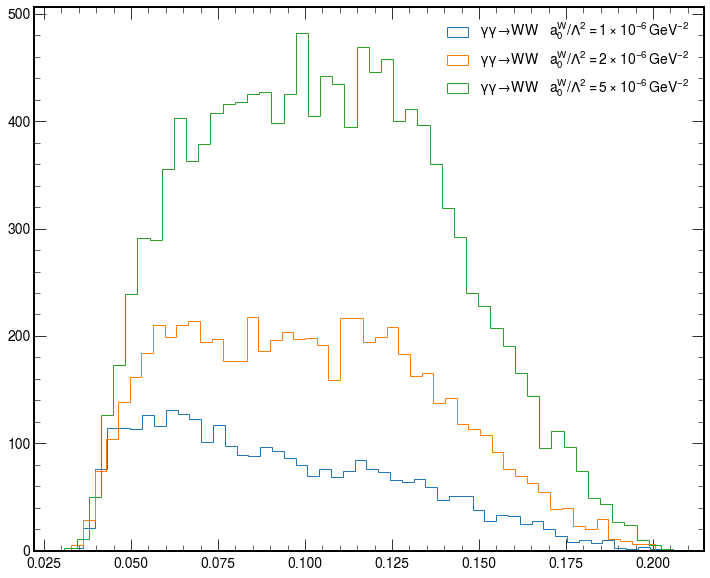

In [8]:
labels_samples = {
    "GGToWW-AQGC-A0W5e-7": r"$\gamma\gamma \to WW \quad a_0^W/\Lambda^2 = 5 \times 10^{-7} \,\rm{GeV}^{-2}$",
    "GGToWW-AQGC-A0W1e-6": r"$\gamma\gamma \to WW \quad a_0^W/\Lambda^2 = 1 \times 10^{-6} \,\rm{GeV}^{-2}$",
    "GGToWW-AQGC-A0W2e-6": r"$\gamma\gamma \to WW \quad a_0^W/\Lambda^2 = 2 \times 10^{-6} \,\rm{GeV}^{-2}$",
    "GGToWW-AQGC-A0W5e-6": r"$\gamma\gamma \to WW \quad a_0^W/\Lambda^2 = 5 \times 10^{-6} \,\rm{GeV}^{-2}$"
}
labels_samples[ "GGToWW-AQGC-muon-A0W1e-6" ] = labels_samples[ "GGToWW-AQGC-A0W1e-6" ]
labels_samples[ "GGToWW-AQGC-muon-A0W2e-6" ] = labels_samples[ "GGToWW-AQGC-A0W2e-6" ]
labels_samples[ "GGToWW-AQGC-muon-A0W5e-6" ] = labels_samples[ "GGToWW-AQGC-A0W5e-6" ]
labels_samples[ "GGToWW-AQGC-electron-A0W1e-6" ] = labels_samples[ "GGToWW-AQGC-A0W1e-6" ]
labels_samples[ "GGToWW-AQGC-electron-A0W2e-6" ] = labels_samples[ "GGToWW-AQGC-A0W2e-6" ]
labels_samples[ "GGToWW-AQGC-electron-A0W5e-6" ] = labels_samples[ "GGToWW-AQGC-A0W5e-6" ]
labels_samples[ "GGToWW-AQGC-2017-muon-A0W1e-6" ] = labels_samples[ "GGToWW-AQGC-A0W1e-6" ]
labels_samples[ "GGToWW-AQGC-2017-muon-A0W2e-6" ] = labels_samples[ "GGToWW-AQGC-A0W2e-6" ]
labels_samples[ "GGToWW-AQGC-2017-muon-A0W5e-6" ] = labels_samples[ "GGToWW-AQGC-A0W5e-6" ]
labels_samples[ "GGToWW-AQGC-2017-electron-A0W1e-6" ] = labels_samples[ "GGToWW-AQGC-A0W1e-6" ]
labels_samples[ "GGToWW-AQGC-2017-electron-A0W2e-6" ] = labels_samples[ "GGToWW-AQGC-A0W2e-6" ]
labels_samples[ "GGToWW-AQGC-2017-electron-A0W5e-6" ] = labels_samples[ "GGToWW-AQGC-A0W5e-6" ]
labels_samples[ "GGToWW-AQGC-2018-muon-A0W5e-7" ] = labels_samples[ "GGToWW-AQGC-A0W5e-7" ]
labels_samples[ "GGToWW-AQGC-2018-muon-A0W1e-6" ] = labels_samples[ "GGToWW-AQGC-A0W1e-6" ]
labels_samples[ "GGToWW-AQGC-2018-muon-A0W2e-6" ] = labels_samples[ "GGToWW-AQGC-A0W2e-6" ]
labels_samples[ "GGToWW-AQGC-2018-muon-A0W5e-6" ] = labels_samples[ "GGToWW-AQGC-A0W5e-6" ]
labels_samples[ "GGToWW-AQGC-2018-electron-A0W5e-7" ] = labels_samples[ "GGToWW-AQGC-A0W5e-7" ]
labels_samples[ "GGToWW-AQGC-2018-electron-A0W1e-6" ] = labels_samples[ "GGToWW-AQGC-A0W1e-6" ]
labels_samples[ "GGToWW-AQGC-2018-electron-A0W2e-6" ] = labels_samples[ "GGToWW-AQGC-A0W2e-6" ]
labels_samples[ "GGToWW-AQGC-2018-electron-A0W5e-6" ] = labels_samples[ "GGToWW-AQGC-A0W5e-6" ]

if load_signal:
    fig = plt.figure( figsize=(12,10) )
    for label_ in labels_signals: 
        plt.hist( df_signals_protons_multiRP_index[ label_ ][ 'xi' ], histtype='step', density=False, bins=50, label=labels_samples[ label_ ] )
    plt.legend( loc='best', fontsize=14 )

In [9]:
import json
samples_info = None
if data_sample == '2017':
    samples_info = json.load( open( 'samples_info_2017.json' ) )
elif data_sample == '2018':
#     samples_info = json.load( open( 'samples_info_2018.json' ) )
#     samples_info = json.load( open( 'samples_info_UL.json' ) )
    samples_info = json.load( open( 'samples_info_UL18_XSDB.json' ) )
samples_info

{'FPMC_WW_bSM_13tev_a0w_1e-6_aCw_0_semi_pt0': [100000.0, 0.045393, 1.0, 6],
 'FPMC_WW_bSM_13tev_a0w_2e-6_aCw_0_semi_pt0': [100000.0, 0.058313, 1.0, 6],
 'FPMC_WW_bSM_13tev_a0w_5e-6_aCw_0_semi_pt0': [100000.0, 0.148122, 1.0, 6],
 'FPMC_WW_bSM_13tev_a0w_0_aCw_2e-5_semi_pt0': [99000.0, 0.16477, 1.0, 6],
 'FPMC_WW_bSM_13tev_a0w_0_aCw_5e-6_semi_pt0': [100000.0, 0.049199, 1.0, 6],
 'FPMC_WW_bSM_13tev_a0w_0_aCw_8e-6_semi_pt0': [100000.0, 0.061404, 1.0, 6],
 'FPMC_WW_bSM_13tev_a0w_0_aCw_0_semi_pt0': [262999.0, 0.0409705, 1.0, 6],
 'TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8': [306142140.0, 831.76, 1.0, 800],
 'WW_TuneCP5_13TeV-pythia8': [15679000.0, 75.95, 1.0, 800],
 'WZ_TuneCP5_13TeV-pythia8': [7940000.0, 27.59, 1.0, 800],
 'ZZ_TuneCP5_13TeV-pythia8': [3526000.0, 12.17, 1.0, 800],
 'ST_s-channel_4f_leptonDecays_TuneCP5_13TeV-amcatnlo-pythia8': [19366000.0,
  3.549,
  1.0,
  800],
 'ST_t-channel_top_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8': [178756000.0,
  115.3,
  1.0,
  800],

In [10]:
lumi_periods = None
if data_sample == '2017':
    if lepton_type == 'muon':
        lumi_periods = lumi_periods_2017[ 'muon' ]
    elif lepton_type == 'electron':
        lumi_periods = lumi_periods_2017[ 'electron' ]
elif data_sample == '2018':
    if lepton_type == 'muon':
        lumi_periods = lumi_periods_2018[ 'muon' ]
    elif lepton_type == 'electron':
        lumi_periods = lumi_periods_2018[ 'electron' ]
    
lumi = np.sum( list( lumi_periods.values() ) )
print ( lumi )

#labels_signals = [ "GGToWW-AQGC-test-A0W1e-6", "GGToWW-AQGC-test-A0W2e-6", "GGToWW-AQGC-test-A0W5e-6" ]
sample_names = {}
if data_sample == '2017':
    if lepton_type == 'muon':
        sample_names[ "GGToWW-AQGC-2017-muon-A0W1e-6" ] = "GGToWW_bSM-A0W1e-6_13TeV-fpmc-herwig6"
        sample_names[ "GGToWW-AQGC-2017-muon-A0W2e-6" ] = "GGToWW_bSM-A0W2e-6_13TeV-fpmc-herwig6"
        sample_names[ "GGToWW-AQGC-2017-muon-A0W5e-6" ] = "GGToWW_bSM-A0W5e-6_13TeV-fpmc-herwig6"
    if lepton_type == 'electron':
        sample_names[ "GGToWW-AQGC-2017-electron-A0W1e-6" ] = "GGToWW_bSM-A0W1e-6_13TeV-fpmc-herwig6"
        sample_names[ "GGToWW-AQGC-2017-electron-A0W2e-6" ] = "GGToWW_bSM-A0W2e-6_13TeV-fpmc-herwig6"
        sample_names[ "GGToWW-AQGC-2017-electron-A0W5e-6" ] = "GGToWW_bSM-A0W5e-6_13TeV-fpmc-herwig6"
elif data_sample == '2018':
    if lepton_type == 'muon':
        sample_names[ "GGToWW-AQGC-2018-muon-A0W1e-6" ] = "FPMC_WW_bSM_13tev_a0w_1e-6_aCw_0_semi_pt0"
        sample_names[ "GGToWW-AQGC-2018-muon-A0W2e-6" ] = "FPMC_WW_bSM_13tev_a0w_2e-6_aCw_0_semi_pt0"
        sample_names[ "GGToWW-AQGC-2018-muon-A0W5e-6" ] = "FPMC_WW_bSM_13tev_a0w_5e-6_aCw_0_semi_pt0"
    if lepton_type == 'electron':
        sample_names[ "GGToWW-AQGC-2018-electron-A0W1e-6" ] = "FPMC_WW_bSM_13tev_a0w_1e-6_aCw_0_semi_pt0"
        sample_names[ "GGToWW-AQGC-2018-electron-A0W2e-6" ] = "FPMC_WW_bSM_13tev_a0w_2e-6_aCw_0_semi_pt0"
        sample_names[ "GGToWW-AQGC-2018-electron-A0W5e-6" ] = "FPMC_WW_bSM_13tev_a0w_5e-6_aCw_0_semi_pt0"
    
norm_factors = {}
for label_ in labels_signals:
    print ( label_ )
    print ( samples_info[ sample_names[ label_ ] ] )
    sample_nevents_, sample_cross_section_, sel_eff_, _ = samples_info[ sample_names[ label_ ] ]
    sample_cross_section_ = sample_cross_section_ * sel_eff_
    if norm_to_1fb:
        sample_cross_section_ = 1.e-03
#     if data_sample == '2018':
#         sample_cross_section_ *= ( 0.14271*(1.174) )
    print ( sample_cross_section_ )
    norm_factors[ label_ ] = np.array( [ lumi / ( sample_nevents_ ), sample_cross_section_*1000, 1.0 ] )
    print ( norm_factors[ label_ ] )
    norm_factors_product_ = np.product( norm_factors[ label_ ] )
#     df_signals_protons_multiRP_events[ label_ ].loc[ :, "norm" ] = norm_factors_product_
    df_signals_protons_multiRP_events[ label_ ][ "_nom" ].loc[ :, "norm" ] = norm_factors_product_

55.700985822999996
GGToWW-AQGC-2018-muon-A0W1e-6
[100000.0, 0.045393, 1.0, 6]
0.045393
[5.57009858e-04 4.53930000e+01 1.00000000e+00]
GGToWW-AQGC-2018-muon-A0W2e-6
[100000.0, 0.058313, 1.0, 6]
0.058313
[5.57009858e-04 5.83130000e+01 1.00000000e+00]
GGToWW-AQGC-2018-muon-A0W5e-6
[100000.0, 0.148122, 1.0, 6]
0.148122
[5.57009858e-04 1.48122000e+02 1.00000000e+00]


/tmp/ipykernel_955/3435712407.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_signals_protons_multiRP_events[ label_ ][ "_nom" ].loc[ :, "norm" ] = norm_factors_product_
/tmp/ipykernel_955/3435712407.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_signals_protons_multiRP_events[ label_ ][ "_nom" ].loc[ :, "norm" ] = norm_factors_product_
/tmp/ipykernel_955/3435712407.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

### Background

### Load and select events

In [11]:
if not bkg_MC_mix_protons: 
    labels_background = []
    fileNames_bkg = {}
    resample_factor = 50
    if data_sample == '2017':
        if lepton_type == 'muon':
            labels_background = [
                "data-random-resample_50-single-arm-muon-2017B",
                "data-random-resample_50-single-arm-muon-2017C",
                "data-random-resample_50-single-arm-muon-2017D",
                "data-random-resample_50-single-arm-muon-2017E",
                "data-random-resample_50-single-arm-muon-2017F"
            ]
            fileNames_bkg = {
                "data-random-resample_50-single-arm-muon-2017B": "data-store-data-random-resample_50-single-arm-2017B.h5",
                "data-random-resample_50-single-arm-muon-2017C": "data-store-data-random-resample_50-single-arm-2017C.h5",
                "data-random-resample_50-single-arm-muon-2017D": "data-store-data-random-resample_50-single-arm-2017D.h5",
                "data-random-resample_50-single-arm-muon-2017E": "data-store-data-random-resample_50-single-arm-2017E.h5",
                "data-random-resample_50-single-arm-muon-2017F": "data-store-data-random-resample_50-single-arm-2017F.h5"
            }
        elif lepton_type == 'electron':
            labels_background = [
                "data-random-resample_50-single-arm-electron-2017B",
                "data-random-resample_50-single-arm-electron-2017C",
                "data-random-resample_50-single-arm-electron-2017D",
                "data-random-resample_50-single-arm-electron-2017E",
                "data-random-resample_50-single-arm-electron-2017F"
            ]
            fileNames_bkg = {
                "data-random-resample_50-single-arm-electron-2017B": "data-store-data-random-resample_50-single-arm-electron-2017B.h5",
                "data-random-resample_50-single-arm-electron-2017C": "data-store-data-random-resample_50-single-arm-electron-2017C.h5",
                "data-random-resample_50-single-arm-electron-2017D": "data-store-data-random-resample_50-single-arm-electron-2017D.h5",
                "data-random-resample_50-single-arm-electron-2017E": "data-store-data-random-resample_50-single-arm-electron-2017E.h5",
                "data-random-resample_50-single-arm-electron-2017F": "data-store-data-random-resample_50-single-arm-electron-2017F.h5"
            }
    elif data_sample == '2018':
        if lepton_type == 'muon':
            labels_background = [
                "data-random-resample_50-2018-muon-2018A",
                "data-random-resample_50-2018-muon-2018B",
                "data-random-resample_50-2018-muon-2018C",
                #"data-random-resample_50-2018-muon-2018D",
                "data-random-resample_50-2018-muon-2018D-1",
                "data-random-resample_50-2018-muon-2018D-2",
                "data-random-resample_50-2018-muon-2018D-3",
                "data-random-resample_50-2018-muon-2018D-4",
                "data-random-resample_50-2018-muon-2018D-5",
                "data-random-resample_50-2018-muon-2018D-6"
            ]
            fileNames_bkg = {
                "data-random-resample_50-2018-muon-2018A": "data-store-data-random-resample_50-2018-muon-2018A.h5",
                "data-random-resample_50-2018-muon-2018B": "data-store-data-random-resample_50-2018-muon-2018B.h5",
                "data-random-resample_50-2018-muon-2018C": "data-store-data-random-resample_50-2018-muon-2018C.h5",
                #"data-random-resample_50-2018-muon-2018D": "data-store-data-random-resample_50-2018-muon-2018D.h5",
                "data-random-resample_50-2018-muon-2018D-1": "data-store-data-random-resample_50-2018-muon-2018D-1.h5",
                "data-random-resample_50-2018-muon-2018D-2": "data-store-data-random-resample_50-2018-muon-2018D-2.h5",
                "data-random-resample_50-2018-muon-2018D-3": "data-store-data-random-resample_50-2018-muon-2018D-3.h5",
                "data-random-resample_50-2018-muon-2018D-4": "data-store-data-random-resample_50-2018-muon-2018D-4.h5",
                "data-random-resample_50-2018-muon-2018D-5": "data-store-data-random-resample_50-2018-muon-2018D-5.h5",
                "data-random-resample_50-2018-muon-2018D-6": "data-store-data-random-resample_50-2018-muon-2018D-6.h5"
            }             
        elif lepton_type == 'electron':
            labels_background = [
                "data-random-resample_50-2018-electron-2018A",
                "data-random-resample_50-2018-electron-2018B",
                "data-random-resample_50-2018-electron-2018C",
                #"data-random-resample_50-2018-electron-2018D",
                "data-random-resample_50-2018-electron-2018D-1",
                "data-random-resample_50-2018-electron-2018D-2",
                "data-random-resample_50-2018-electron-2018D-3",
                "data-random-resample_50-2018-electron-2018D-4",
                "data-random-resample_50-2018-electron-2018D-5",
                "data-random-resample_50-2018-electron-2018D-6"
            ]
            fileNames_bkg = {
                "data-random-resample_50-2018-electron-2018A": "data-store-data-random-resample_50-2018-electron-2018A.h5",
                "data-random-resample_50-2018-electron-2018B": "data-store-data-random-resample_50-2018-electron-2018B.h5",
                "data-random-resample_50-2018-electron-2018C": "data-store-data-random-resample_50-2018-electron-2018C.h5",
                #"data-random-resample_50-2018-electron-2018D": "data-store-data-random-resample_50-2018-electron-2018D.h5",
                "data-random-resample_50-2018-electron-2018D-1": "data-store-data-random-resample_50-2018-electron-2018D-1.h5",
                "data-random-resample_50-2018-electron-2018D-2": "data-store-data-random-resample_50-2018-electron-2018D-2.h5",
                "data-random-resample_50-2018-electron-2018D-3": "data-store-data-random-resample_50-2018-electron-2018D-3.h5",
                "data-random-resample_50-2018-electron-2018D-4": "data-store-data-random-resample_50-2018-electron-2018D-4.h5",
                "data-random-resample_50-2018-electron-2018D-5": "data-store-data-random-resample_50-2018-electron-2018D-5.h5",
                "data-random-resample_50-2018-electron-2018D-6": "data-store-data-random-resample_50-2018-electron-2018D-6.h5"
            }

    
    base_path_ = "output"
#     base_path_ = "output_19-06"
    #base_path_ = "output_new"
    for label_ in fileNames_bkg:
        fileNames_bkg[ label_ ] = "{}/{}".format( base_path_, fileNames_bkg[ label_ ] )
    print ( fileNames_bkg )

    # file_path_ = "{}/data-store-{}.h5".format( base_path_, label )
    # print ( file_path_ )

    df_counts_bkg = None
    # df_protons_multiRP_bkg_index = None
    df_protons_multiRP_bkg_events = None
    df_protons_multiRP_bkg_events_nTracks40 = None

    df_counts_bkg_list_ = []
    # df_protons_multiRP_bkg_index_list_ = []
    df_protons_multiRP_bkg_events_list_ = []
    df_protons_multiRP_bkg_events_list_nTracks40_ = []
    for label_ in labels_background:
        print ( label_ )
        file_path_ = fileNames_bkg[ label_ ]
        print ( file_path_ )
        with pd.HDFStore( file_path_, 'r' ) as store_:
            print ( list( store_ ) )
            
            df_counts_bkg__ = store_[ "counts" ]
    #         df_protons_multiRP_bkg_index__  = store_[ "protons_multiRP" ]
            df_protons_multiRP_bkg_events__ = store_[ "events_multiRP" ]
            if lepton_type == 'muon':
                df_protons_multiRP_bkg_events__ = df_protons_multiRP_bkg_events__.loc[ :, 
                    ['crossingAngle',
                     'jet0_eta', 'jet0_phi', 
                     'jet0_tau1', 'jet0_tau2',
                     'met', 'met_phi',
                     'num_bjets_ak4',
                     'pfcand_nextracks', 'pfcand_nextracks_noDRl',
                     'WLeptonicEta', 'WLeptonicPhi',
                     'muon0_eta', 'muon0_phi', 'muon0_iso',
                     'run_rnd', 'lumiblock_rnd', 'event_rnd', 'crossingAngle_rnd', 'period',
                     'jet0_pt_nom', 'jet0_energy_nom', 'jet0_corrmass_nom',
                     'muon0_pt_nom', 
                     'WLeptonicPt_nom', 
                     'MWW_nom', 'YWW_nom', 'xiCMS_45_nom', 'xiCMS_56_nom', 'xi_nom',
                     'MX_nom', 'YX_nom', 'R_MWW_MX_nom', 'Diff_YWW_YX_nom']
                ]
            if lepton_type == 'electron':
                df_protons_multiRP_bkg_events__ = df_protons_multiRP_bkg_events__.loc[ :, 
                    ['crossingAngle',
                     'jet0_eta', 'jet0_phi', 
                     'jet0_tau1', 'jet0_tau2',
                     'met', 'met_phi',
                     'num_bjets_ak4',
                     'pfcand_nextracks', 'pfcand_nextracks_noDRl',
                     'WLeptonicEta', 'WLeptonicPhi',
                     'electron0_eta', 'electron0_phi', #'electron0_iso',
                     'run_rnd', 'lumiblock_rnd', 'event_rnd', 'crossingAngle_rnd', 'period',
                     'jet0_pt_nom', 'jet0_energy_nom', 'jet0_corrmass_nom',
                     'electron0_pt_nom', 
                     'WLeptonicPt_nom', 
                     'MWW_nom', 'YWW_nom', 'xiCMS_45_nom', 'xiCMS_56_nom', 'xi_nom',
                     'MX_nom', 'YX_nom', 'R_MWW_MX_nom', 'Diff_YWW_YX_nom']
                ]

            print ( df_protons_multiRP_bkg_events__.shape[0] )
            df_protons_multiRP_bkg_events_nTracks40__, selection_keys__, selections__ = select_events( df_protons_multiRP_bkg_events__, lepton_type, max_num_tracks=40 )
            print ( df_protons_multiRP_bkg_events_nTracks40__.shape[0] )
            print ( selection_keys__ )
            print ( selections__ )
            df_protons_multiRP_bkg_events_def__, selection_keys__, selections__ = select_events( df_protons_multiRP_bkg_events__, lepton_type )
            print ( df_protons_multiRP_bkg_events_def__.shape[0] )
            print ( selection_keys__ )
            print ( selections__ )    
    
            df_counts_bkg_list_.append( df_counts_bkg__ )
    #         df_protons_multiRP_bkg_index_list_.append( df_protons_multiRP_bkg_index__ )
    #         df_protons_multiRP_bkg_events_list_.append( df_protons_multiRP_bkg_events__ )
            df_protons_multiRP_bkg_events_list_.append( df_protons_multiRP_bkg_events_def__ )
            df_protons_multiRP_bkg_events_list_nTracks40_.append( df_protons_multiRP_bkg_events_nTracks40__ )

    df_counts_bkg = df_counts_bkg_list_[0]
    for idx_ in range( 1, len( df_counts_bkg_list_ ) ):
        df_counts_bkg = df_counts_bkg.add( df_counts_bkg_list_[ idx_ ] )

    # df_protons_multiRP_bkg_index = pd.concat( df_protons_multiRP_bkg_index_list_ )
    df_protons_multiRP_bkg_events = pd.concat( df_protons_multiRP_bkg_events_list_ )
    df_protons_multiRP_bkg_events_nTracks40 = pd.concat( df_protons_multiRP_bkg_events_list_nTracks40_ )

In [12]:
if bkg_MC_mix_protons:
    labels_background = []
    fileNames_bkg = {}
    resample_factor = 1
    if data_sample == '2017':
        if lepton_type == 'muon':
            labels_background = [ "GGToWW-AQGC-mix_protons-2017-muon-A0W1e-6", "GGToWW-AQGC-mix_protons-2017-muon-A0W2e-6", "GGToWW-AQGC-mix_protons-2017-muon-A0W5e-6" ]
            fileNames_bkg = {
                "GGToWW-AQGC-mix_protons-2017-muon-A0W1e-6": "data-store-GGToWW-AQGC-mix_protons-2018-muon-A0W1e-6.h5",
                "GGToWW-AQGC-mix_protons-2017-muon-A0W2e-6": "data-store-GGToWW-AQGC-mix_protons-2018-muon-A0W2e-6.h5",
                "GGToWW-AQGC-mix_protons-2017-muon-A0W5e-6": "data-store-GGToWW-AQGC-mix_protons-2018-muon-A0W5e-6.h5"
            }
        elif lepton_type == 'electron':
            labels_background = [ "GGToWW-AQGC-mix_protons-2017-electron-A0W1e-6", "GGToWW-AQGC-mix_protons-2017-electron-A0W2e-6", "GGToWW-AQGC-mix_protons-2017-electron-A0W5e-6" ] 
            fileNames_bkg = {
                "GGToWW-AQGC-mix_protons-2017-electron-A0W1e-6": "data-store-GGToWW-AQGC-mix_protons-2018-electron-A0W1e-6.h5",
                "GGToWW-AQGC-mix_protons-2017-electron-A0W2e-6": "data-store-GGToWW-AQGC-mix_protons-2018-electron-A0W2e-6.h5",
                "GGToWW-AQGC-mix_protons-2017-electron-A0W5e-6": "data-store-GGToWW-AQGC-mix_protons-2018-electron-A0W5e-6.h5"
            }
    elif data_sample == '2018':
        if lepton_type == 'muon':
            labels_background = [ "Bkg-mix_protons-2018-muon-TTJets", "Bkg-mix_protons-2018-muon-WJetsToLNu_0J", "Bkg-mix_protons-2018-muon-WJetsToLNu_1J", "Bkg-mix_protons-2018-muon-WJetsToLNu_2J", "Bkg-mix_protons-2018-muon-DYJetsToLL_0J", "Bkg-mix_protons-2018-muon-DYJetsToLL_1J", "Bkg-mix_protons-2018-muon-DYJetsToLL_2J", "Bkg-mix_protons-2018-muon-QCD_Pt_170to300", "Bkg-mix_protons-2018-muon-QCD_Pt_300to470", "Bkg-mix_protons-2018-muon-QCD_Pt_470to600", "Bkg-mix_protons-2018-muon-QCD_Pt_600to800", "Bkg-mix_protons-2018-muon-QCD_Pt_800to1000", "Bkg-mix_protons-2018-muon-QCD_Pt_1000to1400", "Bkg-mix_protons-2018-muon-QCD_Pt_1400to1800", "Bkg-mix_protons-2018-muon-QCD_Pt_1800to2400", "Bkg-mix_protons-2018-muon-QCD_Pt_2400to3200", "Bkg-mix_protons-2018-muon-QCD_Pt_3200toInf", "Bkg-mix_protons-2018-muon-ST_s-channel_4f_leptonDecays", "Bkg-mix_protons-2018-muon-ST_t-channel_antitop_4f_InclusiveDecays", "Bkg-mix_protons-2018-muon-ST_t-channel_top_4f_InclusiveDecays", "Bkg-mix_protons-2018-muon-ST_tW_antitop_5f_inclusiveDecays", "Bkg-mix_protons-2018-muon-ST_tW_top_5f_inclusiveDecays", "Bkg-mix_protons-2018-muon-WW", "Bkg-mix_protons-2018-muon-WZ", "Bkg-mix_protons-2018-muon-ZZ"]
            #labels_background = [ "Bkg-mix_protons-2018-muon-WJetsToLNu_2J", "Bkg-mix_protons-2018-muon-QCD_Pt_300to470", "Bkg-mix_protons-2018-muon-QCD_Pt_470to600", "Bkg-mix_protons-2018-muon-QCD_Pt_600to800", "Bkg-mix_protons-2018-muon-QCD_Pt_800to1000", "Bkg-mix_protons-2018-muon-QCD_Pt_1000to1400", "Bkg-mix_protons-2018-muon-ST_s-channel_4f_leptonDecays", "Bkg-mix_protons-2018-muon-ST_t-channel_antitop_4f_InclusiveDecays", "Bkg-mix_protons-2018-muon-ST_t-channel_top_4f_InclusiveDecays", "Bkg-mix_protons-2018-muon-ST_tW_antitop_5f_inclusiveDecays", "Bkg-mix_protons-2018-muon-ST_tW_top_5f_inclusiveDecays" ] 
            fileNames_bkg = {
                "Bkg-mix_protons-2018-muon-TTJets": "data-store-Bkg-mix_protons-2018-muon-TTJets.h5",
                "Bkg-mix_protons-2018-muon-WJetsToLNu_0J": "data-store-Bkg-mix_protons-2018-muon-WJetsToLNu_0J.h5",
                "Bkg-mix_protons-2018-muon-WJetsToLNu_1J": "data-store-Bkg-mix_protons-2018-muon-WJetsToLNu_1J.h5",
                "Bkg-mix_protons-2018-muon-WJetsToLNu_2J": "data-store-Bkg-mix_protons-2018-muon-WJetsToLNu_2J.h5",
                "Bkg-mix_protons-2018-muon-DYJetsToLL_0J": "data-store-Bkg-mix_protons-2018-muon-DYJetsToLL_0J.h5",
                "Bkg-mix_protons-2018-muon-DYJetsToLL_1J": "data-store-Bkg-mix_protons-2018-muon-DYJetsToLL_1J.h5",
                "Bkg-mix_protons-2018-muon-DYJetsToLL_2J": "data-store-Bkg-mix_protons-2018-muon-DYJetsToLL_2J.h5",
                "Bkg-mix_protons-2018-muon-QCD_Pt_170to300": "data-store-Bkg-mix_protons-2018-muon-QCD_Pt_170to300.h5",
                "Bkg-mix_protons-2018-muon-QCD_Pt_300to470": "data-store-Bkg-mix_protons-2018-muon-QCD_Pt_300to470.h5",
                "Bkg-mix_protons-2018-muon-QCD_Pt_470to600": "data-store-Bkg-mix_protons-2018-muon-QCD_Pt_470to600.h5",
                "Bkg-mix_protons-2018-muon-QCD_Pt_600to800": "data-store-Bkg-mix_protons-2018-muon-QCD_Pt_600to800.h5",
                "Bkg-mix_protons-2018-muon-QCD_Pt_800to1000": "data-store-Bkg-mix_protons-2018-muon-QCD_Pt_800to1000.h5",
                "Bkg-mix_protons-2018-muon-QCD_Pt_1000to1400": "data-store-Bkg-mix_protons-2018-muon-QCD_Pt_1000to1400.h5",
                "Bkg-mix_protons-2018-muon-QCD_Pt_1400to1800": "data-store-Bkg-mix_protons-2018-muon-QCD_Pt_1400to1800.h5",
                "Bkg-mix_protons-2018-muon-QCD_Pt_1800to2400": "data-store-Bkg-mix_protons-2018-muon-QCD_Pt_1800to2400.h5",
                "Bkg-mix_protons-2018-muon-QCD_Pt_2400to3200": "data-store-Bkg-mix_protons-2018-muon-QCD_Pt_2400to3200.h5",
                "Bkg-mix_protons-2018-muon-QCD_Pt_3200toInf": "data-store-Bkg-mix_protons-2018-muon-QCD_Pt_3200toInf.h5",
                "Bkg-mix_protons-2018-muon-ST_s-channel_4f_leptonDecays": "data-store-Bkg-mix_protons-2018-muon-ST_s-channel_4f_leptonDecays.h5",
                "Bkg-mix_protons-2018-muon-ST_t-channel_antitop_4f_InclusiveDecays": "data-store-Bkg-mix_protons-2018-muon-ST_t-channel_antitop_4f_InclusiveDecays.h5",
                "Bkg-mix_protons-2018-muon-ST_t-channel_top_4f_InclusiveDecays": "data-store-Bkg-mix_protons-2018-muon-ST_t-channel_top_4f_InclusiveDecays.h5",
                "Bkg-mix_protons-2018-muon-ST_tW_antitop_5f_inclusiveDecays": "data-store-Bkg-mix_protons-2018-muon-ST_tW_antitop_5f_inclusiveDecays.h5",
                "Bkg-mix_protons-2018-muon-ST_tW_top_5f_inclusiveDecays": "data-store-Bkg-mix_protons-2018-muon-ST_tW_top_5f_inclusiveDecays.h5",
                "Bkg-mix_protons-2018-muon-WW": "data-store-Bkg-mix_protons-2018-muon-WW.h5",
                "Bkg-mix_protons-2018-muon-WZ": "data-store-Bkg-mix_protons-2018-muon-WZ.h5",
                "Bkg-mix_protons-2018-muon-ZZ": "data-store-Bkg-mix_protons-2018-muon-ZZ.h5"
            }
  
        elif lepton_type == 'electron':
            labels_background = [ "Bkg-mix_protons-2018-electron-TTJets", "Bkg-mix_protons-2018-electron-WJetsToLNu_0J", "Bkg-mix_protons-2018-electron-WJetsToLNu_1J", "Bkg-mix_protons-2018-electron-WJetsToLNu_2J", "Bkg-mix_protons-2018-electron-DYJetsToLL_0J", "Bkg-mix_protons-2018-electron-DYJetsToLL_1J", "Bkg-mix_protons-2018-electron-DYJetsToLL_2J", "Bkg-mix_protons-2018-electron-QCD_Pt_170to300", "Bkg-mix_protons-2018-electron-QCD_Pt_300to470", "Bkg-mix_protons-2018-electron-QCD_Pt_470to600", "Bkg-mix_protons-2018-electron-QCD_Pt_600to800", "Bkg-mix_protons-2018-electron-QCD_Pt_800to1000", "Bkg-mix_protons-2018-electron-QCD_Pt_1000to1400", "Bkg-mix_protons-2018-electron-QCD_Pt_1400to1800", "Bkg-mix_protons-2018-electron-QCD_Pt_1800to2400", "Bkg-mix_protons-2018-electron-QCD_Pt_2400to3200", "Bkg-mix_protons-2018-electron-QCD_Pt_3200toInf", "Bkg-mix_protons-2018-electron-ST_s-channel_4f_leptonDecays", "Bkg-mix_protons-2018-electron-ST_t-channel_antitop_4f_InclusiveDecays", "Bkg-mix_protons-2018-electron-ST_t-channel_top_4f_InclusiveDecays", "Bkg-mix_protons-2018-electron-ST_tW_antitop_5f_inclusiveDecays", "Bkg-mix_protons-2018-electron-ST_tW_top_5f_inclusiveDecays", "Bkg-mix_protons-2018-electron-WW", "Bkg-mix_protons-2018-electron-WZ", "Bkg-mix_protons-2018-electron-ZZ" ]
            fileNames_bkg = {
                "Bkg-mix_protons-2018-electron-TTJets": "data-store-Bkg-mix_protons-2018-electron-TTJets.h5",
                "Bkg-mix_protons-2018-electron-WJetsToLNu_0J": "data-store-Bkg-mix_protons-2018-electron-WJetsToLNu_0J.h5",
                "Bkg-mix_protons-2018-electron-WJetsToLNu_1J": "data-store-Bkg-mix_protons-2018-electron-WJetsToLNu_1J.h5",
                "Bkg-mix_protons-2018-electron-WJetsToLNu_2J": "data-store-Bkg-mix_protons-2018-electron-WJetsToLNu_2J.h5",
                "Bkg-mix_protons-2018-electron-DYJetsToLL_0J": "data-store-Bkg-mix_protons-2018-electron-DYJetsToLL_0J.h5",
                "Bkg-mix_protons-2018-electron-DYJetsToLL_1J": "data-store-Bkg-mix_protons-2018-electron-DYJetsToLL_1J.h5",
                "Bkg-mix_protons-2018-electron-DYJetsToLL_2J": "data-store-Bkg-mix_protons-2018-electron-DYJetsToLL_2J.h5",
                "Bkg-mix_protons-2018-electron-QCD_Pt_170to300": "data-store-Bkg-mix_protons-2018-electron-QCD_Pt_170to300.h5",
                "Bkg-mix_protons-2018-electron-QCD_Pt_300to470": "data-store-Bkg-mix_protons-2018-electron-QCD_Pt_300to470.h5",
                "Bkg-mix_protons-2018-electron-QCD_Pt_470to600": "data-store-Bkg-mix_protons-2018-electron-QCD_Pt_470to600.h5",
                "Bkg-mix_protons-2018-electron-QCD_Pt_600to800": "data-store-Bkg-mix_protons-2018-electron-QCD_Pt_600to800.h5",
                "Bkg-mix_protons-2018-electron-QCD_Pt_800to1000": "data-store-Bkg-mix_protons-2018-electron-QCD_Pt_800to1000.h5",
                "Bkg-mix_protons-2018-electron-QCD_Pt_1000to1400": "data-store-Bkg-mix_protons-2018-electron-QCD_Pt_1000to1400.h5",
                "Bkg-mix_protons-2018-electron-QCD_Pt_1400to1800": "data-store-Bkg-mix_protons-2018-electron-QCD_Pt_1400to1800.h5",
                "Bkg-mix_protons-2018-electron-QCD_Pt_1800to2400": "data-store-Bkg-mix_protons-2018-electron-QCD_Pt_1800to2400.h5",
                "Bkg-mix_protons-2018-electron-QCD_Pt_2400to3200": "data-store-Bkg-mix_protons-2018-electron-QCD_Pt_2400to3200.h5",
                "Bkg-mix_protons-2018-electron-QCD_Pt_3200toInf": "data-store-Bkg-mix_protons-2018-electron-QCD_Pt_3200toInf.h5",
                "Bkg-mix_protons-2018-electron-ST_s-channel_4f_leptonDecays": "data-store-Bkg-mix_protons-2018-electron-ST_s-channel_4f_leptonDecays.h5",
                "Bkg-mix_protons-2018-electron-ST_t-channel_antitop_4f_InclusiveDecays": "data-store-Bkg-mix_protons-2018-electron-ST_t-channel_antitop_4f_InclusiveDecays.h5",
                "Bkg-mix_protons-2018-electron-ST_t-channel_top_4f_InclusiveDecays": "data-store-Bkg-mix_protons-2018-electron-ST_t-channel_top_4f_InclusiveDecays.h5",
                "Bkg-mix_protons-2018-electron-ST_tW_antitop_5f_inclusiveDecays": "data-store-Bkg-mix_protons-2018-electron-ST_tW_antitop_5f_inclusiveDecays.h5",
                "Bkg-mix_protons-2018-electron-ST_tW_top_5f_inclusiveDecays": "data-store-Bkg-mix_protons-2018-electron-ST_tW_top_5f_inclusiveDecays.h5",
                "Bkg-mix_protons-2018-electron-WW": "data-store-Bkg-mix_protons-2018-electron-WW.h5",
                "Bkg-mix_protons-2018-electron-WZ": "data-store-Bkg-mix_protons-2018-electron-WZ.h5",
                "Bkg-mix_protons-2018-electron-ZZ": "data-store-Bkg-mix_protons-2018-electron-ZZ.h5"
    
            } 

    df_counts_bkg = {}
    df_protons_multiRP_bkg_index = {}
    df_protons_multiRP_bkg_pre_sel_events = {}
    df_protons_multiRP_bkg_events = {}
    df_protons_multiRP_bkg_events_nTracks40 = {}
    
    base_path_ = "output"
    #base_path_ = "output_new"
    for label_ in labels_background:
        print ( label_ )
        file_path_ = "{}/data-store-{}.h5".format( base_path_, label_ )
        with pd.HDFStore( file_path_, 'r' ) as store_:
            print ( list( store_ ) )
            df_counts_bkg[ label_ ] = store_[ "counts" ]
            df_protons_multiRP_bkg_index[ label_ ] = store_[ "protons_multiRP" ]
            df_protons_multiRP_bkg_pre_sel_events[ label_ ] = store_[ "events_multiRP" ]
            
            df_bkg__ = df_protons_multiRP_bkg_pre_sel_events[ label_ ]
            jet0_tau21_, rhoprime1_, jet0_tau21_ddt_ = tau21_ddt_calculation( df_bkg__, lepton_type )
            df_bkg__["jet0_tau21"] = jet0_tau21_
            df_bkg__["jet0_tau21_ddt"] = jet0_tau21_ddt_
            print ( df_bkg__.shape[0] )
            
            df_protons_multiRP_bkg_events__, selection_keys__, selections__ = select_events( df_bkg__, lepton_type )
            print ( df_protons_multiRP_bkg_events__.shape[0] )
            print ( selection_keys__ )
            print ( selections__ )
            df_protons_multiRP_bkg_events[ label_ ] = {}
            df_protons_multiRP_bkg_events[ label_ ][ "_nom" ] = df_protons_multiRP_bkg_events__
            
            df_protons_multiRP_bkg_events_nTracks40__, selection_keys__, selections__ = select_events( df_bkg__, lepton_type, max_num_tracks=40 )
            print ( df_protons_multiRP_bkg_events_nTracks40__.shape[0] )
            print ( selection_keys__ )
            print ( selections__ )
            df_protons_multiRP_bkg_events_nTracks40[ label_ ] = {}
            df_protons_multiRP_bkg_events_nTracks40[ label_ ][ "_nom" ] = df_protons_multiRP_bkg_events_nTracks40__

Bkg-mix_protons-2018-muon-TTJets
['/counts', '/events_multiRP', '/protons_multiRP']
657932
131
['All', 'Muon', 'Jet', 'MET', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'MWW', 'ExtraTracks']
{'All': 657932, 'Muon': 657054, 'Jet': 508686, 'MET': 432844, 'BJet_Veto': 238732, 'Xi_CMS': 219082, 'WLeptonic': 116004, 'MWW': 109886, 'ExtraTracks': 131}
23414
['All', 'Muon', 'Jet', 'MET', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'MWW', 'ExtraTracks']
{'All': 657932, 'Muon': 657054, 'Jet': 508686, 'MET': 432844, 'BJet_Veto': 238732, 'Xi_CMS': 219082, 'WLeptonic': 116004, 'MWW': 109886, 'ExtraTracks': 23414}
Bkg-mix_protons-2018-muon-WJetsToLNu_0J
['/counts', '/events_multiRP', '/protons_multiRP']
1
0
['All', 'Muon', 'Jet', 'MET', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'MWW', 'ExtraTracks']
{'All': 1, 'Muon': 1, 'Jet': 0, 'MET': 0, 'BJet_Veto': 0, 'Xi_CMS': 0, 'WLeptonic': 0, 'MWW': 0, 'ExtraTracks': 0}
0
['All', 'Muon', 'Jet', 'MET', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'MWW', 'ExtraTracks']
{'All': 1, 'Muon': 

['/counts', '/events_multiRP', '/protons_multiRP']
25574
26
['All', 'Muon', 'Jet', 'MET', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'MWW', 'ExtraTracks']
{'All': 25574, 'Muon': 25573, 'Jet': 20049, 'MET': 16728, 'BJet_Veto': 11144, 'Xi_CMS': 9803, 'WLeptonic': 4969, 'MWW': 4534, 'ExtraTracks': 26}
1666
['All', 'Muon', 'Jet', 'MET', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'MWW', 'ExtraTracks']
{'All': 25574, 'Muon': 25573, 'Jet': 20049, 'MET': 16728, 'BJet_Veto': 11144, 'Xi_CMS': 9803, 'WLeptonic': 4969, 'MWW': 4534, 'ExtraTracks': 1666}
Bkg-mix_protons-2018-muon-ST_t-channel_antitop_4f_InclusiveDecays
['/counts', '/events_multiRP', '/protons_multiRP']
33033
18
['All', 'Muon', 'Jet', 'MET', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'MWW', 'ExtraTracks']
{'All': 33033, 'Muon': 33030, 'Jet': 24239, 'MET': 20103, 'BJet_Veto': 12587, 'Xi_CMS': 11418, 'WLeptonic': 5475, 'MWW': 5053, 'ExtraTracks': 18}
1922
['All', 'Muon', 'Jet', 'MET', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'MWW', 'ExtraTracks']
{'All': 33033,

/cvmfs/sft.cern.ch/lcg/views/LCG_103swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/cvmfs/sft.cern.ch/lcg/views/LCG_103swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


68716
40
['All', 'Muon', 'Jet', 'MET', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'MWW', 'ExtraTracks']
{'All': 68716, 'Muon': 68711, 'Jet': 51974, 'MET': 43364, 'BJet_Veto': 27076, 'Xi_CMS': 23447, 'WLeptonic': 11358, 'MWW': 10545, 'ExtraTracks': 40}
3869
['All', 'Muon', 'Jet', 'MET', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'MWW', 'ExtraTracks']
{'All': 68716, 'Muon': 68711, 'Jet': 51974, 'MET': 43364, 'BJet_Veto': 27076, 'Xi_CMS': 23447, 'WLeptonic': 11358, 'MWW': 10545, 'ExtraTracks': 3869}
Bkg-mix_protons-2018-muon-ST_tW_antitop_5f_inclusiveDecays
['/counts', '/events_multiRP', '/protons_multiRP']
12987
9
['All', 'Muon', 'Jet', 'MET', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'MWW', 'ExtraTracks']
{'All': 12987, 'Muon': 12978, 'Jet': 10133, 'MET': 8770, 'BJet_Veto': 5995, 'Xi_CMS': 5509, 'WLeptonic': 3699, 'MWW': 3475, 'ExtraTracks': 9}
1134
['All', 'Muon', 'Jet', 'MET', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'MWW', 'ExtraTracks']
{'All': 12987, 'Muon': 12978, 'Jet': 10133, 'MET': 8770, 'BJet_Veto': 5

In [13]:
if not bkg_MC_mix_protons:
    print(df_protons_multiRP_bkg_events)
if bkg_MC_mix_protons:
    print(df_protons_multiRP_bkg_events[ label_ ][ "_nom" ])

Empty DataFrame
Columns: [crossingAngle, betaStar, instLumi, jet0_pt, jet0_eta, jet0_phi, jet0_energy, jet0_mass, jet0_corrmass, jet0_tau1, jet0_tau2, jet0_vertexz, jet0_px, jet0_py, jet0_pz, calo_met, met, met_x, met_y, met_phi, nVertices, num_bjets_ak8, num_bjets_ak4, num_jets_ak4, pfcand_nextracks, pfcand_nextracks_noDRl, recoMWhad, recoMWlep, recoMWlep_metJER_Up, recoMWlep_metJER_Down, recoMWlep_metJES_Up, recoMWlep_metJES_Down, recoMWW, recoMWW_metJER_Up, recoMWW_metJER_Down, recoMWW_metJES_Up, recoMWW_metJES_Down, recoRapidityWW, dphiWW, WLeptonicPt, WLeptonicPt_metJER_Up, WLeptonicPt_metJER_Down, WLeptonicPt_metJES_Up, WLeptonicPt_metJES_Down, WLeptonicEta, WLeptonicPhi, muon0_pt, muon0_eta, muon0_phi, muon0_energy, muon0_charge, muon0_iso, muon0_dxy, muon0_dz, muon0_trackerLayersWithMeasurement, muon0_Roccor, muon0_deltaRoccor, run_mc, pileupWeight, mc_pu_trueinteractions, mcWeight, prefiring_weight, prefiring_weight_up, prefiring_weight_down, prefiring_weight_ECAL, prefiring_w

In [14]:
df_counts_bkg

{'Bkg-mix_protons-2018-muon-TTJets': All                     6021909
 Jet                     6021909
 Muon                    3272782
 ProtonRnd_check_none    3272723
 ProtonRnd               2371823
 dtype: int64,
 'Bkg-mix_protons-2018-muon-WJetsToLNu_0J': All                     31
 Jet                     31
 Muon                    10
 ProtonRnd_check_none    10
 ProtonRnd               10
 dtype: int64,
 'Bkg-mix_protons-2018-muon-WJetsToLNu_1J': All                     194347
 Jet                     194347
 Muon                    104127
 ProtonRnd_check_none    104122
 ProtonRnd                75043
 dtype: int64,
 'Bkg-mix_protons-2018-muon-WJetsToLNu_2J': All                     762414
 Jet                     762414
 Muon                    410005
 ProtonRnd_check_none    410002
 ProtonRnd               296975
 dtype: int64,
 'Bkg-mix_protons-2018-muon-DYJetsToLL_0J': All                     544
 Jet                     544
 Muon                    182
 ProtonRnd_check_non

In [15]:
if not bkg_MC_mix_protons:
    print(df_protons_multiRP_bkg_events.columns.values)

In [16]:
if not bkg_MC_mix_protons:
    print(df_protons_multiRP_bkg_events_nTracks40)
if bkg_MC_mix_protons:
    print(df_protons_multiRP_bkg_events_nTracks40[ label_ ][ "_nom" ])

                                                  crossingAngle  betaStar  \
run lumiblock event   hash_id              slice                            
1   3785      3784490 18395116950545856016 0              152.0       0.4   
    3205      3204004 9519908240150364782  0              152.0       0.4   
    611       610544  9401318436790889972  0              152.0       0.4   
    1641      1640322 2135381007580962984  0              152.0       0.4   
    1415      1414383 6609433040531334226  0              152.0       0.4   
...                                                         ...       ...   
    2233      2232627 2015317220958999744  0              152.0       0.4   
    2589      2588369 4356948006037931616  0              152.0       0.4   
    1065      1064704 2716972176314377083  0              152.0       0.4   
    2580      2579724 6438717405707867632  0              152.0       0.4   
    1979      1978647 12714330463096826320 0              152.0       0.4   

In [17]:
if not bkg_MC_mix_protons:
    norm_factors['Bkg'] = np.array( [ ( 1. / resample_factor ) ] )
    df_protons_multiRP_bkg_events_nTracks40[ "norm" ] = np.product( norm_factors['Bkg'] )
    df_protons_multiRP_bkg_events[ "norm" ] = np.product( norm_factors['Bkg'] )

In [18]:
if bkg_MC_mix_protons:
    labels_samples_bkg = {
        "Bkg-mix_protons-2018-muon-TTJets": r"$t \bar{t} + \rm{jets}$",
        "Bkg-mix_protons-2018-electron-TTJets": r"$t \bar{t} + \rm{jets}$",
        "Bkg-mix_protons-2018-muon-WJetsToLNu_0J": r"$W + 0\rm{jet}$",
        "Bkg-mix_protons-2018-electron-WJetsToLNu_0J": r"$W + 0\rm{jet}$",
        "Bkg-mix_protons-2018-muon-WJetsToLNu_1J": r"$W + 1\rm{jet}$",
        "Bkg-mix_protons-2018-electron-WJetsToLNu_1J": r"$W + 1\rm{jet}$",
        "Bkg-mix_protons-2018-muon-WJetsToLNu_2J": r"$W + 2\rm{jets}$",
        "Bkg-mix_protons-2018-electron-WJetsToLNu_2J": r"$W + 2\rm{jets}$",
        "Bkg-mix_protons-2018-muon-WJetsToLNu": r"$W + \rm{jets}$",
        "Bkg-mix_protons-2018-electron-WJetsToLNu": r"$W + \rm{jets}$",
        "Bkg-mix_protons-2018-muon-DYJetsToLL_0J": r"$\rm{DY} + 0\rm{jet}$",
        "Bkg-mix_protons-2018-electron-DYJetsToLL_0J": r"$\rm{DY} + 0\rm{jet}$",
        "Bkg-mix_protons-2018-muon-DYJetsToLL_1J": r"$\rm{DY} + 1\rm{jet}$",
        "Bkg-mix_protons-2018-electron-DYJetsToLL_1J": r"$\rm{DY} + 1\rm{jet}$",
        "Bkg-mix_protons-2018-muon-DYJetsToLL_2J": r"$\rm{DY} + 2\rm{jet}$",
        "Bkg-mix_protons-2018-electron-DYJetsToLL_2J": r"$\rm{DY} + 2\rm{jet}$",
        "Bkg-mix_protons-2018-muon-DYJetsToLL": r"$\rm{DY} + \rm{jets}$",
        "Bkg-mix_protons-2018-electron-DYJetsToLL": r"$\rm{DY} + \rm{jets}$",
        "Bkg-mix_protons-2018-muon-QCD_Pt_170to300": r"QCD $170$--$300\,\rm{GeV}$",
        "Bkg-mix_protons-2018-electron-QCD_Pt_170to300": r"QCD $170$--$300\,\rm{GeV}$",
        "Bkg-mix_protons-2018-muon-QCD_Pt_300to470": r"QCD $300$--$470\,\rm{GeV}$",
        "Bkg-mix_protons-2018-electron-QCD_Pt_300to470": r"QCD $300$--$470\,\rm{GeV}$",
        "Bkg-mix_protons-2018-muon-QCD_Pt_470to600": r"QCD $470$--$600\,\rm{GeV}$",
        "Bkg-mix_protons-2018-electron-QCD_Pt_470to600": r"QCD $470$--$600\,\rm{GeV}$",
        "Bkg-mix_protons-2018-muon-QCD_Pt_600to800": r"QCD $600$--$800\,\rm{GeV}$",
        "Bkg-mix_protons-2018-electron-QCD_Pt_600to800": r"QCD $600$--$800\,\rm{GeV}$",
        "Bkg-mix_protons-2018-muon-QCD_Pt_800to1000": r"QCD $800$--$1000\,\rm{GeV}$",
        "Bkg-mix_protons-2018-electron-QCD_Pt_800to1000": r"QCD $800$--$1000\,\rm{GeV}$",
        "Bkg-mix_protons-2018-muon-QCD_Pt_1000to1400": r"QCD $1000$--$1400\,\rm{GeV}$",
        "Bkg-mix_protons-2018-electron-QCD_Pt_1000to1400": r"QCD $1000$--$1400\,\rm{GeV}$",
        "Bkg-mix_protons-2018-muon-QCD_Pt_1400to1800": r"QCD $1400$--$1800\,\rm{GeV}$",
        "Bkg-mix_protons-2018-electron-QCD_Pt_1400to1800": r"QCD $1400$--$1800\,\rm{GeV}$",
        "Bkg-mix_protons-2018-muon-QCD_Pt_1800to2400": r"QCD $1800$--$2400\,\rm{GeV}$",
        "Bkg-mix_protons-2018-electron-QCD_Pt_1800to2400": r"QCD $1800$--$2400\,\rm{GeV}$",
        "Bkg-mix_protons-2018-muon-QCD_Pt_2400to3200": r"QCD $2400$--$3200\,\rm{GeV}$",
        "Bkg-mix_protons-2018-electron-QCD_Pt_2400to3200": r"QCD $2400$--$3200\,\rm{GeV}$",
        "Bkg-mix_protons-2018-muon-QCD_Pt_3200toInf": r"QCD $3200$--$\,\rm{GeV}$",
        "Bkg-mix_protons-2018-electron-QCD_Pt_3200toInf": r"QCD $3200$--$\,\rm{GeV}$",
        "Bkg-mix_protons-2018-muon-QCD": r"QCD",
        "Bkg-mix_protons-2018-electron-QCD": r"QCD",
        "Bkg-mix_protons-2018-muon-ST_s-channel_4f_leptonDecays": r"single top $s$-channel $4f$",
        "Bkg-mix_protons-2018-electron-ST_s-channel_4f_leptonDecays": r"single top $s$-channel $4f$",
        "Bkg-mix_protons-2018-muon-ST_t-channel_antitop_4f_InclusiveDecays": r"single top $t$-channel $\bar{t}$ $4f$",
        "Bkg-mix_protons-2018-electron-ST_t-channel_antitop_4f_InclusiveDecays": r"single top $t$-channel $\bar{t}$ $4f$",
        "Bkg-mix_protons-2018-muon-ST_t-channel_top_4f_InclusiveDecays": r"single top $t$-channel $t$ $4f$",
        "Bkg-mix_protons-2018-electron-ST_t-channel_top_4f_InclusiveDecays": r"single top $t$-channel $t$ $4f$",
        "Bkg-mix_protons-2018-muon-ST_tW_antitop_5f_inclusiveDecays": r"single top $tW$ $\bar{t}$ $5f$",
        "Bkg-mix_protons-2018-electron-ST_tW_antitop_5f_inclusiveDecays": r"single top $tW$ $\bar{t}$ $5f$",
        "Bkg-mix_protons-2018-muon-ST_tW_top_5f_inclusiveDecays": r"single top $tW$ $t$ $5f$",
        "Bkg-mix_protons-2018-electron-ST_tW_top_5f_inclusiveDecays": r"single top $tW$ $t$ $5f$",
        "Bkg-mix_protons-2018-muon-ST": r"single top",
        "Bkg-mix_protons-2018-electron-ST": r"single top",
        "Bkg-mix_protons-2018-muon-WW": r"$WW$",
        "Bkg-mix_protons-2018-electron-WW": r"$WW$",
        "Bkg-mix_protons-2018-muon-WZ": r"$WZ$",
        "Bkg-mix_protons-2018-electron-WZ": r"$WZ$",
        "Bkg-mix_protons-2018-muon-ZZ": r"$ZZ$",
        "Bkg-mix_protons-2018-electron-ZZ": r"$ZZ$",
        "Bkg-mix_protons-2018-muon-VV": r"$VV$",
        "Bkg-mix_protons-2018-electron-VV": r"$VV$"
}

In [19]:
if bkg_MC_mix_protons:
    sample_names_bkg = {}
    if data_sample == '2017':
        pass
    elif data_sample == '2018':
        sample_names_bkg[ "Bkg-mix_protons-2018-muon-TTJets" ] = 'TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-muon-WJetsToLNu_0J" ] = 'WJetsToLNu_0J_TuneCP5_13TeV-amcatnloFXFX-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-muon-WJetsToLNu_1J" ] = 'WJetsToLNu_1J_TuneCP5_13TeV-amcatnloFXFX-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-muon-WJetsToLNu_2J" ] = 'WJetsToLNu_2J_TuneCP5_13TeV-amcatnloFXFX-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-muon-DYJetsToLL_0J" ] = 'DYJetsToLL_0J_TuneCP5_13TeV-amcatnloFXFX-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-muon-DYJetsToLL_1J" ] = 'DYJetsToLL_1J_TuneCP5_13TeV-amcatnloFXFX-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-muon-DYJetsToLL_2J" ] = 'DYJetsToLL_2J_TuneCP5_13TeV-amcatnloFXFX-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-muon-QCD_Pt_300to470" ] = 'QCD_Pt_300to470_TuneCP5_13TeV-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-muon-QCD_Pt_470to600" ] = 'QCD_Pt_470to600_TuneCP5_13TeV-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-muon-QCD_Pt_600to800" ] = 'QCD_Pt_600to800_TuneCP5_13TeV-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-muon-QCD_Pt_800to1000" ] = 'QCD_Pt_800to1000_TuneCP5_13TeV-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-muon-QCD_Pt_1000to1400" ] = 'QCD_Pt_1000to1400_TuneCP5_13TeV-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-muon-QCD_Pt_170to300" ] = 'QCD_Pt_170to300_TuneCP5_13TeV-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-muon-QCD_Pt_1400to1800" ] = 'QCD_Pt_1400to1800_TuneCP5_13TeV-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-muon-QCD_Pt_1800to2400" ] = 'QCD_Pt_1800to2400_TuneCP5_13TeV-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-muon-QCD_Pt_2400to3200" ] = 'QCD_Pt_2400to3200_TuneCP5_13TeV-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-muon-QCD_Pt_3200toInf" ] = 'QCD_Pt_3200toInf_TuneCP5_13TeV-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-muon-ST_s-channel_4f_leptonDecays" ] = 'ST_s-channel_4f_leptonDecays_TuneCP5_13TeV-amcatnlo-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-muon-ST_t-channel_antitop_4f_InclusiveDecays" ] = 'ST_t-channel_antitop_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-muon-ST_t-channel_top_4f_InclusiveDecays" ] = 'ST_t-channel_top_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-muon-ST_tW_antitop_5f_inclusiveDecays" ] = 'ST_tW_antitop_5f_inclusiveDecays_TuneCP5_13TeV-powheg-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-muon-ST_tW_top_5f_inclusiveDecays" ] = 'ST_tW_top_5f_inclusiveDecays_TuneCP5_13TeV-powheg-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-muon-WW" ] = 'WW_TuneCP5_13TeV-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-muon-WZ" ] = 'WZ_TuneCP5_13TeV-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-muon-ZZ" ] = 'ZZ_TuneCP5_13TeV-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-electron-TTJets" ] = 'TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-electron-WJetsToLNu_0J" ] = 'WJetsToLNu_0J_TuneCP5_13TeV-amcatnloFXFX-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-electron-WJetsToLNu_1J" ] = 'WJetsToLNu_1J_TuneCP5_13TeV-amcatnloFXFX-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-electron-WJetsToLNu_2J" ] = 'WJetsToLNu_2J_TuneCP5_13TeV-amcatnloFXFX-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-electron-DYJetsToLL_0J" ] = 'DYJetsToLL_0J_TuneCP5_13TeV-amcatnloFXFX-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-electron-DYJetsToLL_1J" ] = 'DYJetsToLL_1J_TuneCP5_13TeV-amcatnloFXFX-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-electron-DYJetsToLL_2J" ] = 'DYJetsToLL_2J_TuneCP5_13TeV-amcatnloFXFX-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-electron-QCD_Pt_170to300" ] = 'QCD_Pt_170to300_TuneCP5_13TeV-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-electron-QCD_Pt_300to470" ] = 'QCD_Pt_300to470_TuneCP5_13TeV-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-electron-QCD_Pt_470to600" ] = 'QCD_Pt_470to600_TuneCP5_13TeV-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-electron-QCD_Pt_600to800" ] = 'QCD_Pt_600to800_TuneCP5_13TeV-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-electron-QCD_Pt_800to1000" ] = 'QCD_Pt_800to1000_TuneCP5_13TeV-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-electron-QCD_Pt_1000to1400" ] = 'QCD_Pt_1000to1400_TuneCP5_13TeV-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-electron-QCD_Pt_1400to1800" ] = 'QCD_Pt_1400to1800_TuneCP5_13TeV-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-electron-QCD_Pt_1800to2400" ] = 'QCD_Pt_1800to2400_TuneCP5_13TeV-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-electron-QCD_Pt_2400to3200" ] = 'QCD_Pt_2400to3200_TuneCP5_13TeV-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-electron-QCD_Pt_3200toInf" ] = 'QCD_Pt_3200toInf_TuneCP5_13TeV-pythia8'      
        sample_names_bkg[ "Bkg-mix_protons-2018-electron-ST_s-channel_4f_leptonDecays" ] = 'ST_s-channel_4f_leptonDecays_TuneCP5_13TeV-amcatnlo-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-electron-ST_t-channel_antitop_4f_InclusiveDecays" ] = 'ST_t-channel_antitop_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-electron-ST_t-channel_top_4f_InclusiveDecays" ] = 'ST_t-channel_top_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-electron-ST_tW_antitop_5f_inclusiveDecays" ] = 'ST_tW_antitop_5f_inclusiveDecays_TuneCP5_13TeV-powheg-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-electron-ST_tW_top_5f_inclusiveDecays" ] = 'ST_tW_top_5f_inclusiveDecays_TuneCP5_13TeV-powheg-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-electron-WW" ] = 'WW_TuneCP5_13TeV-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-electron-WZ" ] = 'WZ_TuneCP5_13TeV-pythia8'
        sample_names_bkg[ "Bkg-mix_protons-2018-electron-ZZ" ] = 'ZZ_TuneCP5_13TeV-pythia8'
        

In [20]:
if bkg_MC_mix_protons:
    lumi_periods = None
    if data_sample == '2017':
        if lepton_type == 'muon':
            lumi_periods = lumi_periods_2017[ 'muon' ]
        elif lepton_type == 'electron':
            lumi_periods = lumi_periods_2017[ 'electron' ]
    elif data_sample == '2018':
        if lepton_type == 'muon':
            lumi_periods = lumi_periods_2018[ 'muon' ]
        elif lepton_type == 'electron':
            lumi_periods = lumi_periods_2018[ 'electron' ]
    
    lumi = np.sum( list( lumi_periods.values() ) )
    print ( lumi )
    
    norm_factors = {}
    for label__ in labels_background:
        print ( label__ )
        print ( samples_info[ sample_names_bkg[ label__ ] ] )
        sample_nevents_, sample_cross_section_, sel_eff_, _ = samples_info[ sample_names_bkg[ label__ ] ]
        sample_cross_section_ = sample_cross_section_ * sel_eff_
#         if norm_to_1fb:
#             sample_cross_section_ = 1.e-03
        print ( sample_cross_section_ )
        norm_factors[ label__ ] = np.array( [ lumi / ( sample_nevents_ ), sample_cross_section_*1000, 1.0 ] )
        print ( norm_factors[ label__ ] )
        norm_factors_product_ = np.product( norm_factors[ label__ ] )
        print ( norm_factors_product_ )
        if df_protons_multiRP_bkg_events[ label__ ][ "_nom" ].shape[0] > 0:
            df_protons_multiRP_bkg_events[ label__ ][ "_nom" ].loc[ :, "norm" ] = norm_factors_product_

        if df_protons_multiRP_bkg_events_nTracks40[ label__ ][ "_nom" ].shape[0] > 0:
            df_protons_multiRP_bkg_events_nTracks40[ label__ ][ "_nom" ].loc[ :, "norm" ] = norm_factors_product_

55.700985822999996
Bkg-mix_protons-2018-muon-TTJets
[306142140.0, 831.76, 1.0, 800]
831.76
[1.8194485e-07 8.3176000e+05 1.0000000e+00]
0.1513344486588435
Bkg-mix_protons-2018-muon-WJetsToLNu_0J
[172138160.0, 53330, 1.0, 800]
53330.0
[3.23583021e-07 5.33300000e+07 1.00000000e+00]
17.256682503987435
Bkg-mix_protons-2018-muon-WJetsToLNu_1J
[184528800.0, 8875, 1.0, 800]
8875.0
[3.01855243e-07 8.87500000e+06 1.00000000e+00]
2.678965284438662
Bkg-mix_protons-2018-muon-WJetsToLNu_2J
[94925912.0, 3338, 1.0, 800]
3338.0
[5.86783784e-07 3.33800000e+06 1.00000000e+00]
1.9586842702883276
Bkg-mix_protons-2018-muon-DYJetsToLL_0J
[86443200.0, 5129, 1.0, 800]
5129.0
[6.44365153e-07 5.12900000e+06 1.00000000e+00]
3.304948871468976
Bkg-mix_protons-2018-muon-DYJetsToLL_1J
[92022392.0, 951.5, 1.0, 800]
951.5
[6.05298174e-07 9.51500000e+05 1.00000000e+00]
0.5759412123364985
Bkg-mix_protons-2018-muon-DYJetsToLL_2J
[44735476.0, 361.4, 1.0, 800]
361.4
[1.24511888e-06 3.61400000e+05 1.00000000e+00]
0.449985963

/tmp/ipykernel_955/2511536575.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_protons_multiRP_bkg_events[ label__ ][ "_nom" ].loc[ :, "norm" ] = norm_factors_product_
/tmp/ipykernel_955/2511536575.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_protons_multiRP_bkg_events_nTracks40[ label__ ][ "_nom" ].loc[ :, "norm" ] = norm_factors_product_
/tmp/ipykernel_955/2511536575.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

In [21]:
df_protons_multiRP_bkg_events

{'Bkg-mix_protons-2018-muon-TTJets': {'_nom':                                                     crossingAngle  betaStar  \
  run lumiblock event     hash_id              slice                            
  1   333282    865531072 3067476322126789550  0              130.0       0.4   
      183714    477104416 14372263161239323330 0              130.0       0.4   
      199690    518593856 9241054030097436233  0              130.0       0.4   
      330810    859112576 8394107359294755329  0              136.0       0.4   
      346390    899574592 6081843443291978272  0              130.0       0.4   
  ...                                                           ...       ...   
      327703    851042688 7614687941723531033  0              148.0       0.4   
      102986    267452480 13505390417776303666 0              136.0       0.4   
      96162     249731296 8893450568764156467  0              154.0       0.4   
      202236    525204416 16796297908291406143 0              156

In [22]:
variations_weights_ = [ "nom" ]

if lepton_type == 'muon':
    variations_weights_sf_muon_id_ = [ "sf_muon_id_up", "sf_muon_id_dw" ]
    variations_weights_.extend( variations_weights_sf_muon_id_ )
    variations_weights_sf_muon_trigger_ = [ "sf_muon_trigger_up", "sf_muon_trigger_dw" ]
    variations_weights_.extend( variations_weights_sf_muon_trigger_ )
elif lepton_type == 'electron':
    variations_weights_sf_electron_id_ = [ "sf_electron_id_up", "sf_electron_id_dw" ]
    variations_weights_.extend( variations_weights_sf_electron_id_ )
    variations_weights_sf_electron_trigger_ = [ "sf_electron_trigger_up", "sf_electron_trigger_dw" ]
    variations_weights_.extend( variations_weights_sf_electron_trigger_ )
    
variations_weights_sf_prefiring_ = [ "sf_prefiring_up", "sf_prefiring_dw" ]
variations_weights_.extend( variations_weights_sf_prefiring_ )

var_names_sf_lepton_id__ = {}
if lepton_type == 'muon':
    for key_ in [ "nom",
                  "sf_prefiring_up", "sf_prefiring_dw",
                  "sf_muon_trigger_up", "sf_muon_trigger_dw" ]: var_names_sf_lepton_id__[ key_ ] = "sf_muon_id"
    var_names_sf_lepton_id__[ "sf_muon_id_up" ] = "sf_muon_id_up"
    var_names_sf_lepton_id__[ "sf_muon_id_dw" ] = "sf_muon_id_dw"
elif lepton_type == 'electron':
    for key_ in [ "nom",
                  "sf_prefiring_up", "sf_prefiring_dw",
                  "sf_electron_trigger_up", "sf_electron_trigger_dw" ]: var_names_sf_lepton_id__[ key_ ] = "sf_electron_id"
    var_names_sf_lepton_id__[ "sf_electron_id_up" ] = "sf_electron_id_up"
    var_names_sf_lepton_id__[ "sf_electron_id_dw" ] = "sf_electron_id_dw"
    
var_names_sf_trigger__ = {}
if lepton_type == 'muon':
    for key_ in [ "nom",
                  "sf_prefiring_up", "sf_prefiring_dw",
                  "sf_muon_id_up", "sf_muon_id_dw" ]:
        var_names_sf_trigger__[ key_ ] = "sf_muon_trigger"
    var_names_sf_trigger__[ "sf_muon_trigger_up" ] = "sf_muon_trigger_up"
    var_names_sf_trigger__[ "sf_muon_trigger_dw" ] = "sf_muon_trigger_dw"
elif lepton_type == 'electron':
    for key_ in [ "nom",
                  "sf_prefiring_up", "sf_prefiring_dw",
                  "sf_electron_id_up", "sf_electron_id_dw" ]:
        var_names_sf_trigger__[ key_ ] = "sf_electron_trigger"
    var_names_sf_trigger__[ "sf_electron_trigger_up" ] = "sf_electron_trigger_up"
    var_names_sf_trigger__[ "sf_electron_trigger_dw" ] = "sf_electron_trigger_dw"

var_names_sf_prefiring__ = {}
if lepton_type == 'muon':
    for key_ in [ "nom",
                  "sf_muon_id_up", "sf_muon_id_dw",
                  "sf_muon_trigger_up", "sf_muon_trigger_dw" ]:
        var_names_sf_prefiring__[ key_ ] = "prefiring_weight_Muon"
        var_names_sf_prefiring__[ "sf_prefiring_up" ] = "prefiring_weight_Muon_up"
        var_names_sf_prefiring__[ "sf_prefiring_dw" ] = "prefiring_weight_Muon_down"
elif lepton_type == 'electron':
    for key_ in [ "nom",
                  "sf_electron_id_up", "sf_electron_id_dw",
                  "sf_electron_trigger_up", "sf_electron_trigger_dw" ]:
        var_names_sf_prefiring__[ key_ ] = "prefiring_weight_ECAL"
        var_names_sf_prefiring__[ "sf_prefiring_up" ] = "prefiring_weight_ECAL_up"
        var_names_sf_prefiring__[ "sf_prefiring_dw" ] = "prefiring_weight_ECAL_down"
# var_names_sf_prefiring__[ "sf_prefiring_up" ] = "prefiring_weight_up"
# var_names_sf_prefiring__[ "sf_prefiring_dw" ] = "prefiring_weight_down"
    
print ( variations_weights_ )
print ( var_names_sf_lepton_id__ )
print ( var_names_sf_trigger__ )
print ( var_names_sf_prefiring__ )

weights_events_bkg = {}
weights_events_sig = {}
for label__ in labels_background:
    print ( label__ )
    
    weights_events_bkg[ label__ ] = {}
    for var_weights__ in variations_weights_:
        weights_events_bkg[ label__ ][ var_weights__ ] = {}
        for variation__ in df_protons_multiRP_bkg_events[ label__ ]:
            df_selected_events__ = df_protons_multiRP_bkg_events[ label__ ][ variation__ ]
            if df_selected_events__.shape[0] > 0:
                weights_events_bkg[ label__ ][ var_weights__ ][ variation__ ] = ( df_selected_events__[ "norm" ] * 
                                                                                 df_selected_events__[ "pileupWeight" ] *
                                                                                 df_selected_events__[ var_names_sf_lepton_id__[ var_weights__ ] ]*
                                                                                 df_selected_events__[ var_names_sf_trigger__[ var_weights__ ] ] *
                                                                                 df_selected_events__[ var_names_sf_prefiring__[ var_weights__ ] ] )

print ( weights_events_bkg )

for label__ in labels_signals:
    print ( label__ )
    
    weights_events_sig[ label__ ] = {}
    for var_weights__ in variations_weights_:
        weights_events_sig[ label__ ][ var_weights__ ] = {}
        for variation__ in df_signals_protons_multiRP_events[ label__ ]:
            df_selected_events__ = df_signals_protons_multiRP_events[ label__ ][ variation__ ]
            if df_selected_events__.shape[0] > 0:
                weights_events_sig[ label__ ][ var_weights__ ][ variation__ ] = ( df_selected_events__[ "norm" ] * 
                                                                                 df_selected_events__[ "pileupWeight" ] *
                                                                                 df_selected_events__[ var_names_sf_lepton_id__[ var_weights__ ] ]*
                                                                                 df_selected_events__[ var_names_sf_trigger__[ var_weights__ ] ] *
                                                                                 df_selected_events__[ var_names_sf_prefiring__[ var_weights__ ] ] )

print ( weights_events_sig )

['nom', 'sf_muon_id_up', 'sf_muon_id_dw', 'sf_muon_trigger_up', 'sf_muon_trigger_dw', 'sf_prefiring_up', 'sf_prefiring_dw']
{'nom': 'sf_muon_id', 'sf_prefiring_up': 'sf_muon_id', 'sf_prefiring_dw': 'sf_muon_id', 'sf_muon_trigger_up': 'sf_muon_id', 'sf_muon_trigger_dw': 'sf_muon_id', 'sf_muon_id_up': 'sf_muon_id_up', 'sf_muon_id_dw': 'sf_muon_id_dw'}
{'nom': 'sf_muon_trigger', 'sf_prefiring_up': 'sf_muon_trigger', 'sf_prefiring_dw': 'sf_muon_trigger', 'sf_muon_id_up': 'sf_muon_trigger', 'sf_muon_id_dw': 'sf_muon_trigger', 'sf_muon_trigger_up': 'sf_muon_trigger_up', 'sf_muon_trigger_dw': 'sf_muon_trigger_dw'}
{'nom': 'prefiring_weight_Muon', 'sf_prefiring_up': 'prefiring_weight_Muon_up', 'sf_prefiring_dw': 'prefiring_weight_Muon_down', 'sf_muon_id_up': 'prefiring_weight_Muon', 'sf_muon_id_dw': 'prefiring_weight_Muon', 'sf_muon_trigger_up': 'prefiring_weight_Muon', 'sf_muon_trigger_dw': 'prefiring_weight_Muon'}
Bkg-mix_protons-2018-muon-TTJets
Bkg-mix_protons-2018-muon-WJetsToLNu_0J
Bkg-m

In [23]:
label_WJetsToLNu = ''
samples_WJetsToLNu = []
label_DYJetsToLL = ''
samples_DYJetsToLL = []
label_QCD = ''
samples_QCD = []
label_ST = ''
samples_ST = []
label_VV = ''
samples_VV = []
if data_sample == '2017':
    if lepton_type == 'muon':
        label_WJetsToLNu = ''
        samples_WJetsToLNu = [ ]
        label_DYJetsToLL = ''
        samples_DYJetsToLL = []
        label_QCD = ''
        samples_QCD = []
        label_ST = ''
        samples_ST = []
        label_VV = ''
        samples_VV = []
    elif lepton_type == 'electron':
        label_WJetsToLNu = ''
        samples_WJetsToLNu = [ ]
        label_DYJetsToLL = ''
        samples_DYJetsToLL = []
        label_QCD = ''
        samples_QCD = []
        label_ST = ''
        samples_ST = []
        label_VV = ''
        samples_VV = []
elif data_sample == '2018':
    if lepton_type == 'muon':
        label_WJetsToLNu = "Bkg-mix_protons-2018-muon-WJetsToLNu"
        samples_WJetsToLNu = [ "Bkg-mix_protons-2018-muon-WJetsToLNu_0J", "Bkg-mix_protons-2018-muon-WJetsToLNu_1J", "Bkg-mix_protons-2018-muon-WJetsToLNu_2J" ]
        label_DYJetsToLL = "Bkg-mix_protons-2018-muon-DYJetsToLL"
        samples_DYJetsToLL = [ "Bkg-mix_protons-2018-muon-DYJetsToLL_0J", "Bkg-mix_protons-2018-muon-DYJetsToLL_1J", "Bkg-mix_protons-2018-muon-DYJetsToLL_2J" ]
        label_QCD = "Bkg-mix_protons-2018-muon-QCD"
        samples_QCD = [ "Bkg-mix_protons-2018-muon-QCD_Pt_170to300", "Bkg-mix_protons-2018-muon-QCD_Pt_300to470", "Bkg-mix_protons-2018-muon-QCD_Pt_470to600",
                        "Bkg-mix_protons-2018-muon-QCD_Pt_600to800","Bkg-mix_protons-2018-muon-QCD_Pt_800to1000", "Bkg-mix_protons-2018-muon-QCD_Pt_1000to1400",
                        "Bkg-mix_protons-2018-muon-QCD_Pt_1400to1800", "Bkg-mix_protons-2018-muon-QCD_Pt_1800to2400", "Bkg-mix_protons-2018-muon-QCD_Pt_2400to3200", "Bkg-mix_protons-2018-muon-QCD_Pt_3200toInf" ]
        label_ST = "Bkg-mix_protons-2018-muon-ST"
        samples_ST = [ "Bkg-mix_protons-2018-muon-ST_s-channel_4f_leptonDecays", "Bkg-mix_protons-2018-muon-ST_t-channel_antitop_4f_InclusiveDecays",
                       "Bkg-mix_protons-2018-muon-ST_t-channel_top_4f_InclusiveDecays","Bkg-mix_protons-2018-muon-ST_tW_antitop_5f_inclusiveDecays", "Bkg-mix_protons-2018-muon-ST_tW_top_5f_inclusiveDecays" ]
        label_VV = "Bkg-mix_protons-2018-muon-VV"
        samples_VV = [ "Bkg-mix_protons-2018-muon-WW",
                       "Bkg-mix_protons-2018-muon-WZ",
                       "Bkg-mix_protons-2018-muon-ZZ" ]
    elif lepton_type == 'electron':
        label_WJetsToLNu = "Bkg-mix_protons-2018-electron-WJetsToLNu"
        samples_WJetsToLNu = [ "Bkg-mix_protons-2018-electron-WJetsToLNu_0J", "Bkg-mix_protons-2018-electron-WJetsToLNu_1J", "Bkg-mix_protons-2018-electron-WJetsToLNu_2J" ]
        label_DYJetsToLL = "Bkg-mix_protons-2018-electron-DYJetsToLL"
        samples_DYJetsToLL = [ "Bkg-mix_protons-2018-electron-DYJetsToLL_0J", "Bkg-mix_protons-2018-electron-DYJetsToLL_1J", "Bkg-mix_protons-2018-electron-DYJetsToLL_2J" ]
        label_QCD = "Bkg-mix_protons-2018-electron-QCD"
        samples_QCD = [ "Bkg-mix_protons-2018-electron-QCD_Pt_170to300", "Bkg-mix_protons-2018-electron-QCD_Pt_300to470", "Bkg-mix_protons-2018-electron-QCD_Pt_470to600",
                        "Bkg-mix_protons-2018-electron-QCD_Pt_600to800","Bkg-mix_protons-2018-electron-QCD_Pt_800to1000", "Bkg-mix_protons-2018-electron-QCD_Pt_1000to1400",
                        "Bkg-mix_protons-2018-electron-QCD_Pt_1400to1800", "Bkg-mix_protons-2018-electron-QCD_Pt_1800to2400", "Bkg-mix_protons-2018-electron-QCD_Pt_2400to3200", "Bkg-mix_protons-2018-electron-QCD_Pt_3200toInf" ]
        label_ST = "Bkg-mix_protons-2018-electron-ST"
        samples_ST = [ "Bkg-mix_protons-2018-electron-ST_s-channel_4f_leptonDecays", "Bkg-mix_protons-2018-electron-ST_t-channel_antitop_4f_InclusiveDecays",
                       "Bkg-mix_protons-2018-electron-ST_t-channel_top_4f_InclusiveDecays","Bkg-mix_protons-2018-electron-ST_tW_antitop_5f_inclusiveDecays", "Bkg-mix_protons-2018-electron-ST_tW_top_5f_inclusiveDecays" ]
        label_VV = "Bkg-mix_protons-2018-electron-VV"
        samples_VV = [ "Bkg-mix_protons-2018-electron-WW",
                       "Bkg-mix_protons-2018-electron-WZ",
                       "Bkg-mix_protons-2018-electron-ZZ" ]

df_protons_multiRP_bkg_events[ label_WJetsToLNu ] = {}
df_protons_multiRP_bkg_events[ label_DYJetsToLL ] = {}
df_protons_multiRP_bkg_events[ label_QCD ] = {}
df_protons_multiRP_bkg_events[ label_ST ] = {}
df_protons_multiRP_bkg_events[ label_VV ] = {}
df_protons_multiRP_bkg_events_nTracks40[ label_WJetsToLNu ] = {}
df_protons_multiRP_bkg_events_nTracks40[ label_DYJetsToLL ] = {}
df_protons_multiRP_bkg_events_nTracks40[ label_QCD ] = {}
df_protons_multiRP_bkg_events_nTracks40[ label_ST ] = {}
df_protons_multiRP_bkg_events_nTracks40[ label_VV ] = {}

weights_events_bkg[ label_WJetsToLNu ] = {}
weights_events_bkg[ label_DYJetsToLL ] = {}
weights_events_bkg[ label_QCD ] = {}
weights_events_bkg[ label_ST ] = {}
weights_events_bkg[ label_VV ]= {}  

for variation__ in df_protons_multiRP_bkg_events[ samples_WJetsToLNu[ 1 ] ]:
    print ( variation__ )
    df_events_list__ = []
    for label__ in samples_WJetsToLNu:
        df_events_list__.append( df_protons_multiRP_bkg_events[ label__ ][ variation__ ] )     
    df_protons_multiRP_bkg_events[ label_WJetsToLNu ][ variation__ ] = pd.concat( df_events_list__ )
    
    df_events_list__ = []
    for label__ in samples_DYJetsToLL:
        df_events_list__.append( df_protons_multiRP_bkg_events[ label__ ][ variation__ ] )
    df_protons_multiRP_bkg_events[ label_DYJetsToLL ][ variation__ ] = pd.concat( df_events_list__ )

    df_events_list__ = []
    for label__ in samples_QCD:
        df_events_list__.append( df_protons_multiRP_bkg_events[ label__ ][ variation__ ] )
    df_protons_multiRP_bkg_events[ label_QCD ][ variation__ ] = pd.concat( df_events_list__ )
    
    df_events_list__ = []
    for label__ in samples_ST:
        df_events_list__.append( df_protons_multiRP_bkg_events[ label__ ][ variation__ ] )
    df_protons_multiRP_bkg_events[ label_ST ][ variation__ ] = pd.concat( df_events_list__ )
    
    df_events_list__ = []
    for label__ in samples_VV:
        df_events_list__.append( df_protons_multiRP_bkg_events[ label__ ][ variation__ ] )
    df_protons_multiRP_bkg_events[ label_VV ][ variation__ ] = pd.concat( df_events_list__ )

for var_weights__ in weights_events_bkg[ samples_WJetsToLNu[ 0 ] ]:
    weights_events_bkg[ label_WJetsToLNu ][ var_weights__ ] = {}
    weights_events_bkg[ label_DYJetsToLL ][ var_weights__ ] = {}
    weights_events_bkg[ label_QCD ][ var_weights__ ] = {}
    weights_events_bkg[ label_ST ][ var_weights__ ] = {}
    weights_events_bkg[ label_VV ][ var_weights__ ] = {}   
    
    for variation__ in weights_events_bkg[ samples_WJetsToLNu[ 1 ] ][ var_weights__ ]:
        weights_events_list__ = []
        for label__ in samples_WJetsToLNu:
            if df_protons_multiRP_bkg_events[ label__ ][ variation__ ].shape[0] > 0:
                weights_events_list__.append( weights_events_bkg[ label__ ][ var_weights__ ][ variation__ ] )
        weights_events_bkg[ label_WJetsToLNu ][ var_weights__ ][ variation__ ] = pd.concat( weights_events_list__ )

        weights_events_list__ = []
        for label__ in samples_DYJetsToLL:
            if df_protons_multiRP_bkg_events[ label__ ][ variation__ ].shape[0] > 0:
                weights_events_list__.append( weights_events_bkg[ label__ ][ var_weights__ ][ variation__ ] )
        weights_events_bkg[ label_DYJetsToLL ][ var_weights__ ][ variation__ ] = pd.concat( weights_events_list__ )    

        weights_events_list__ = []
        for label__ in samples_QCD:
            if df_protons_multiRP_bkg_events[ label__ ][ variation__ ].shape[0] > 0:
                weights_events_list__.append( weights_events_bkg[ label__ ][ var_weights__ ][ variation__ ] )
        weights_events_bkg[ label_QCD ][ var_weights__ ][ variation__ ] = pd.concat( weights_events_list__ )

        weights_events_list__ = []
        for label__ in samples_ST:
            weights_events_list__.append( weights_events_bkg[ label__ ][ var_weights__ ][ variation__ ] )
        weights_events_bkg[ label_ST ][ var_weights__ ][ variation__ ] = pd.concat( weights_events_list__ )

        weights_events_list__ = []
        for label__ in samples_VV:
            if df_protons_multiRP_bkg_events[ label__ ][ variation__ ].shape[0] > 0:
                weights_events_list__.append( weights_events_bkg[ label__ ][ var_weights__ ][ variation__ ] )
        weights_events_bkg[ label_VV ][ var_weights__ ][ variation__ ] = pd.concat( weights_events_list__ )

labels_background.append( label_WJetsToLNu )
labels_background.append( label_DYJetsToLL )
labels_background.append( label_QCD )
labels_background.append( label_ST )
labels_background.append( label_VV )
# print ( df_selected_events_MC[ label_WJetsToLNu ] )

for variation__ in df_protons_multiRP_bkg_events_nTracks40[ samples_WJetsToLNu[ 1 ] ]:
    print ( variation__ )
    df_events_list__ = []
    for label__ in samples_WJetsToLNu:
        df_events_list__.append( df_protons_multiRP_bkg_events_nTracks40[ label__ ][ variation__ ] )
    df_protons_multiRP_bkg_events_nTracks40[ label_WJetsToLNu ][ variation__ ] = pd.concat( df_events_list__ )
    
    df_events_list__ = []
    for label__ in samples_DYJetsToLL:
        df_events_list__.append( df_protons_multiRP_bkg_events_nTracks40[ label__ ][ variation__ ] )
    df_protons_multiRP_bkg_events_nTracks40[ label_DYJetsToLL ][ variation__ ] = pd.concat( df_events_list__ )

    df_events_list__ = []
    for label__ in samples_QCD:
        df_events_list__.append( df_protons_multiRP_bkg_events_nTracks40[ label__ ][ variation__ ] )
    df_protons_multiRP_bkg_events_nTracks40[ label_QCD ][ variation__ ] = pd.concat( df_events_list__ )
    
    df_events_list__ = []
    for label__ in samples_ST:
        df_events_list__.append( df_protons_multiRP_bkg_events_nTracks40[ label__ ][ variation__ ] )
    df_protons_multiRP_bkg_events_nTracks40[ label_ST ][ variation__ ] = pd.concat( df_events_list__ )
    
    df_events_list__ = []
    for label__ in samples_VV:
        df_events_list__.append( df_protons_multiRP_bkg_events_nTracks40[ label__ ][ variation__ ] )
    df_protons_multiRP_bkg_events_nTracks40[ label_VV ][ variation__ ] = pd.concat( df_events_list__ )
    
labels_background.append( label_WJetsToLNu )
labels_background.append( label_DYJetsToLL )
labels_background.append( label_QCD )
labels_background.append( label_ST )
labels_background.append( label_VV )

_nom
_nom


In [24]:
weights_events_bkg

{'Bkg-mix_protons-2018-muon-TTJets': {'nom': {'_nom': run  lumiblock  event      hash_id               slice
   1    333282     865531072  3067476322126789550   0        0.146761
        183714     477104416  14372263161239323330  0        0.158937
        199690     518593856  9241054030097436233   0        0.147864
        330810     859112576  8394107359294755329   0        0.138593
        346390     899574592  6081843443291978272   0        0.147687
                                                               ...   
        327703     851042688  7614687941723531033   0        0.133627
        102986     267452480  13505390417776303666  0        0.145932
        96162      249731296  8893450568764156467   0        0.126132
        202236     525204416  16796297908291406143  0        0.145952
        321050     833765440  9051215447190912562   0        0.177321
   Length: 131, dtype: float64},
  'sf_muon_id_up': {'_nom': run  lumiblock  event      hash_id               slice
   1 

In [25]:
df_protons_multiRP_bkg_events[ label_WJetsToLNu ]

{'_nom':                                                     crossingAngle  betaStar  \
 run lumiblock event     hash_id              slice                            
 1   136015    701018496 16397580023068404028 0              156.0       0.4   
     33181     171014208 16015004047913451341 0              130.0       0.4   
     60476     311690688 16109488637495982763 0              153.0       0.4   
     28071     144673872 14389229834632792096 0              148.0       0.4   
     89653     462071424 14510615950888192431 0              135.0       0.4   
 ...                                                           ...       ...   
     57884     349039424 15554376397115168570 0              136.0       0.4   
     69485     418991072 15320550967249381824 0              130.0       0.4   
     114448    690118784 3198624762648282130  0              156.0       0.4   
     77060     464671712 14501610513366008174 0              137.0       0.4   
     88567     534057600 2689982

In [26]:
labels_bkg_plot = []
if data_sample == '2017':
    if lepton_type == 'muon':
        labels_bkg_plot = [ ]
    elif lepton_type == 'electron':
        labels_bkg_plot = [ ]
elif data_sample == '2018':
    if lepton_type == 'muon':
        labels_bkg_plot = [ "Bkg-mix_protons-2018-muon-WJetsToLNu", "Bkg-mix_protons-2018-muon-DYJetsToLL", "Bkg-mix_protons-2018-muon-TTJets", "Bkg-mix_protons-2018-muon-QCD", "Bkg-mix_protons-2018-muon-ST", "Bkg-mix_protons-2018-muon-VV" ]
    elif lepton_type == 'electron':
        labels_bkg_plot = [ "Bkg-mix_protons-2018-electron-WJetsToLNu", "Bkg-mix_protons-2018-electron-DYJetsToLL", "Bkg-mix_protons-2018-electron-TTJets", "Bkg-mix_protons-2018-electron-QCD", "Bkg-mix_protons-2018-electron-ST", "Bkg-mix_protons-2018-electron-VV" ]

### Data

In [27]:
labels_data = []
fileNames_data = {}
if data_sample == '2017':
    if lepton_type == 'muon':
        labels_data = [ "data-single-arm" ]
        fileNames_data = {
            "data-single-arm": "data-store-data-single-arm.h5"
        }
    elif lepton_type == 'electron':
        labels_data = [ "data-single-arm-electron" ]
        fileNames_data = {
            "data-single-arm-electron": "data-store-data-single-arm-electron.h5"
        }
elif data_sample == '2018':
    if lepton_type == 'muon':
        labels_data = [
            "data-2018-muon-2018A",
            "data-2018-muon-2018B",
            "data-2018-muon-2018C",
            "data-2018-muon-2018D"
        ]
        fileNames_data = {
            "data-2018-muon-2018A": "data-store-data-2018-muon-2018A.h5",
            "data-2018-muon-2018B": "data-store-data-2018-muon-2018B.h5",
            "data-2018-muon-2018C": "data-store-data-2018-muon-2018C.h5",
            "data-2018-muon-2018D": "data-store-data-2018-muon-2018D.h5"
        }
    elif lepton_type == 'electron':
        labels_data = [
            "data-2018-electron-2018A",
            "data-2018-electron-2018B",
            "data-2018-electron-2018C",
            "data-2018-electron-2018D"
        ]
        fileNames_data = {
            "data-2018-electron-2018A": "data-store-data-2018-electron-2018A.h5",
            "data-2018-electron-2018B": "data-store-data-2018-electron-2018B.h5",
            "data-2018-electron-2018C": "data-store-data-2018-electron-2018C.h5",
            "data-2018-electron-2018D": "data-store-data-2018-electron-2018D.h5"
        }     
        

base_path_ = "output"
# base_path_ = "output_19-06"
#base_path_ = "output_new"
for label_ in fileNames_data:
    fileNames_data[ label_ ] = "{}/{}".format( base_path_, fileNames_data[ label_ ] )
print ( fileNames_data )

df_counts_data = None
df_protons_multiRP_data_events = None

df_counts_data_list_ = []
df_protons_multiRP_data_events_list_ = []
for label_ in labels_data:
    print ( label_ )
    file_path_ = fileNames_data[ label_ ]
    print ( file_path_ )
    with pd.HDFStore( file_path_, 'r' ) as store_:
        print ( list( store_ ) )
        
        df_counts_data__ = store_[ "counts" ]
        df_protons_multiRP_data_events__ = store_[ "events_multiRP" ]
        
        jet0_tau21_, rhoprime1_, jet0_tau21_ddt_ = tau21_ddt_calculation( df_protons_multiRP_data_events__, lepton_type )
        df_protons_multiRP_data_events__["jet0_tau21"] = jet0_tau21_
        df_protons_multiRP_data_events__["jet0_tau21_ddt"] = jet0_tau21_ddt_
        
        df_counts_data_list_.append( df_counts_data__ )
        df_protons_multiRP_data_events_list_.append( df_protons_multiRP_data_events__ )

df_counts_data = df_counts_data_list_[0]
for idx_ in range( 1, len( df_counts_data_list_ ) ):
    df_counts_data = df_counts_data.add( df_counts_data_list_[ idx_ ] )

df_protons_multiRP_data_events = pd.concat( df_protons_multiRP_data_events_list_ )

{'data-2018-muon-2018A': 'output/data-store-data-2018-muon-2018A.h5', 'data-2018-muon-2018B': 'output/data-store-data-2018-muon-2018B.h5', 'data-2018-muon-2018C': 'output/data-store-data-2018-muon-2018C.h5', 'data-2018-muon-2018D': 'output/data-store-data-2018-muon-2018D.h5'}
data-2018-muon-2018A
output/data-store-data-2018-muon-2018A.h5
['/counts', '/events_multiRP', '/protons_multiRP']


/cvmfs/sft.cern.ch/lcg/views/LCG_103swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


data-2018-muon-2018B
output/data-store-data-2018-muon-2018B.h5
['/counts', '/events_multiRP', '/protons_multiRP']
data-2018-muon-2018C
output/data-store-data-2018-muon-2018C.h5
['/counts', '/events_multiRP', '/protons_multiRP']
data-2018-muon-2018D
output/data-store-data-2018-muon-2018D.h5
['/counts', '/events_multiRP', '/protons_multiRP']


In [28]:
print ( df_protons_multiRP_data_events.shape[0] )
df_protons_multiRP_data_events_nTracks40, selection_keys_, selections_ = select_events( df_protons_multiRP_data_events, lepton_type, max_num_tracks=40 )
print ( df_protons_multiRP_data_events_nTracks40.shape[0] )
print ( selection_keys_ )
print ( selections_ )
df_protons_multiRP_data_events__, selection_keys_, selections_ = select_events( df_protons_multiRP_data_events, lepton_type )
df_protons_multiRP_data_events = df_protons_multiRP_data_events__
print ( df_protons_multiRP_data_events.shape[0] )
print ( selection_keys_ )
print ( selections_ )

396166


/cvmfs/sft.cern.ch/lcg/views/LCG_103swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


51539
['All', 'Muon', 'Jet', 'MET', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'MWW', 'ExtraTracks']
{'All': 396166, 'Muon': 395537, 'Jet': 283142, 'MET': 219712, 'BJet_Veto': 194819, 'Xi_CMS': 168417, 'WLeptonic': 104023, 'MWW': 94546, 'ExtraTracks': 51539}
532
['All', 'Muon', 'Jet', 'MET', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'MWW', 'ExtraTracks']
{'All': 396166, 'Muon': 395537, 'Jet': 283142, 'MET': 219712, 'BJet_Veto': 194819, 'Xi_CMS': 168417, 'WLeptonic': 104023, 'MWW': 94546, 'ExtraTracks': 532}


In [29]:
df_counts_data

All                  2020639
Jet                  2020639
Muon                 1956930
Proton_check_none    1956930
Proton               1419801
dtype: int64

In [30]:
df_protons_multiRP_data_events

crossingAngle  betaStar   instLumi  \
run    lumiblock event      slice                                       
316199 1150      1593267968 0              136.0       0.3  11.232357   
315713 230       303484704  0              160.0       0.3  16.462006   
316201 91        110693176  0              133.0       0.3  10.365681   
315713 153       195907200  0              160.0       0.3  17.454824   
316059 118       133256976  0              144.0       0.3  14.064011   
...                                          ...       ...        ...   
325022 931       1415486464 0              138.0       0.3  11.476371   
       1229      1753060224 0              133.0       0.3   9.746872   
325099 259       521605984  0              149.0       0.3  15.597985   
325170 115       220471520  0              143.0       0.3  12.149100   
       453       844728384  0              136.0       0.3  10.264283   

                                      jet0_pt  jet0_eta  jet0_phi  \
run    lumiblock event      slice                                   
316199 1150      1593267968 0      266.705231 -2.022364 -1.392227   
315713 230       303484704  0      224.480316 -1.928395  2.367416   
316201 91        110693176  0      278.414001 -0.034178 -1.964605   
315713 153       195907200  0      314.655426  1.385514  1.460674   
316059 118       133256976  0      390.736115 -1.424890  0.798938   
...                                       ...       ...       ...   
325022 931       1415486464 0      260.852051  0.972865  0.310635   
       1229      1753060224 0      223.733826  1.789034 -2.744693   
325099 259       521605984  0      228.143173 -1.509047  3.078791   
325170 115       220471520  0      271.397247 -1.744358 -2.204699   
       453       844728384  0      355.115967  1.842074 -2.726687   

                                   jet0_energy  jet0_mass  jet0_corrmass  \
run    lumiblock event      slice                                          
316199 1150      1593267968 0      1026.383667   5.928849       6.562925   
315713 230       303484704  0       790.090027   6.465564       7.315707   
316201 91        110693176  0       282.955872  12.706948      13.829060   
315713 153       195907200  0       673.228333  19.122263      21.871321   
316059 118       133256976  0       862.634277  11.335527      12.816881   
...                                        ...        ...            ...   
325022 931       1415486464 0       397.693817  18.391436      20.336370   
       1229      1753060224 0       689.853577   6.502131       7.301402   
325099 259       521605984  0       543.273682   8.190495       9.370129   
325170 115       220471520  0       803.957031  12.263670      13.666542   
       453       844728384  0      1149.645508   7.962465       8.768867   

                                   jet0_tau1  ...  diffYWW_YX       MX_nom  \
run    lumiblock event      slice             ...                            
316199 1150      1593267968 0       0.075960  ...   -0.775163   880.127393   
315713 230       303484704  0       0.114636  ...   -0.820399   644.791737   
316201 91        110693176  0       0.117083  ...   -0.087712   782.047745   
315713 153       195907200  0       0.152728  ...    1.546075  1952.764779   
316059 118       133256976  0       0.098614  ...   -1.323409  1264.844216   
...                                      ...  ...         ...          ...   
325022 931       1415486464 0       0.133360  ...    0.917789   837.294951   
       1229      1753060224 0       0.118445  ...    0.600216   815.629952   
325099 259       521605984  0       0.118896  ...    0.133582  1293.147735   
325170 115       220471520  0       0.196781  ...   -1.116855   933.943868   
       453       844728384  0       0.053640  ...    0.677241   876.993954   

                                     YX_nom  R_MWW_MX_nom  Diff_YWW_YX_nom  \
run    lumiblock event      slice                                            
316199 1150      1593267968

In [31]:
weights_events_bkg['Bkg-mix_protons-2018-muon-DYJetsToLL']

{'nom': {'_nom': run  lumiblock  event      hash_id               slice
  1    16141      76491048   3696043805053916480   0        0.526964
       59142      280269504  10477520992719571378  0        0.567097
       58079      275233472  6867533745004430908   0        0.584229
       11262      53368896   3263715087222969889   0        0.573078
       40838      193529760  17455835269910879245  0        0.546214
       94071      445799904  2199733859749001120   0        0.549985
       3278       15531063   8053263577597732781   0        0.560316
       1597       7565783    13310625848079791404  0        0.569498
       97822      463577536  11852557523710542812  0        0.576116
       13919      65960132   1514199754591673285   0        0.543662
       72310      342675456  9025889887015017567   0        0.549106
       19592      92843224   2197081431166013882   0        0.559079
       31399      148797648  1621831783279838816   0        0.488844
       78532      372160480  19

In [37]:
var_str__ = {}
var_str__[ "_nom" ] = "_nom"
var_weights__ = "nom"

def plot_sideband( sideband_type, plot_var, variation, df_bkg_events, df_data__ ):
    sideband_type__ = sideband_type
    plot_var__ = plot_var
    variation__ = variation
#     if sideband_type__ == "pruned_mass":
#         var1__ = ( "jet0_corrmass" + "_nom" ) 
#         var2__ = ( "jet0_tau21_ddt" )
#         var5__ = ( "deltaR_jet_lep" )
#         var6__ = ( "deltaPhi_jet_met" ) 
#         var7__ = ( "deltaPhi_jet_Wlep" )
#         #var4__ = ( "jet0_tau21" )
#     elif sideband_type__ == "tau21_ddt":
#         var1__ = ( "jet0_tau21_ddt" )
#         #var1__ = ( "jet0_tau21" )
#         var4__ = ( "jet0_corrmass" + "_nom" )
#         var5__ = ( "deltaR_jet_lep" )
#         var6__ = ( "deltaPhi_jet_met" ) 
#         var7__ = ( "deltaPhi_jet_Wlep" )
#     elif sideband_type__ = "back_to_back"    
#         var1__ = ( "jet0_corrmass" + "_nom" ) 
#         var4__ = ( "jet0_tau21_ddt" )
#         var5__ = ( "deltaR_jet_lep" )
#         var6__ = ( "deltaPhi_jet_met" ) 
#         var7__ = ( "deltaPhi_jet_Wlep" )
#         #var4__ = ( "jet0_tau21" )
    var2__ = ( "R_MWW_MX" + "_nom" )
    var3__ = ( "Diff_YWW_YX" + "_nom" )

    n_events_bkg = []
    err_n_events_bkg = []
    n_events_sig = []
    err_n_events_sig = []
    
    arr_data_MC_mskA_ = []
    weights_data_MC_mskA_ = []
    arr_signal_mskA_ = []
    weights_signal__mskA_ = []
    n_events_bkg_mskA = []
    err_n_events_bkg_mskA = []
    n_events_bkg_mskA_expected = []
    err_n_events_bkg_mskA_expected = []
    n_events_sig_mskA = []
    err_n_events_sig_mskA = []
#     n_events_sig_mskA_expected = []
#     err_n_events_sig_mskA_expected = []
    
    arr_data_MC_mskB_ = []
    weights_data_MC_mskB_ = []
    arr_signal_mskB_ = []
    weights_signal__mskB_ = []
    n_events_bkg_mskB = []
    err_n_events_bkg_mskB = []
    n_events_sig_mskB = []
    err_n_events_sig_mskB = []
    
    arr_data_MC_mskC_ = []
    weights_data_MC_mskC_ = []
    arr_signal_mskC_ = []
    weights_signal__mskC_ = []
    n_events_bkg_mskC = []
    err_n_events_bkg_mskC = []
    n_events_sig_mskC = []
    err_n_events_sig_mskC = []
    
    arr_data_MC_mskD_ = []
    weights_data_MC_mskD_ = []
    arr_signal_mskD_ = []
    weights_signal__mskD_ = []
    n_events_bkg_mskD = []
    err_n_events_bkg_mskD = []
    n_events_sig_mskD = []
    err_n_events_sig_mskD = []
    
    colors_MC_ = []
    colors_sig_ = []
    labels_MC_ = []
    labels_sig_ = []
    
    colors_MC = [ "blue", "dimgray", "orange", "red", "cyan", "lime" ]
    colors_sig = [ "lightblue", "black", "lightcoral" ]

    linestyles_ = [ "solid", "dashed", (0, (3, 5, 1, 5)), (0, (3, 5, 1, 5, 1, 5)) ] 
    
    if sideband_type__ == "pruned_mass":
        msk_data_cut1 = ( ( df_data__[ "jet0_corrmass" + "_nom" ] >= 50.0 ) & ( df_data__[ "jet0_corrmass" + "_nom" ] <= 110.0 ) )
        msk_data_selection = ( ( df_data__[ "deltaR_jet_lep" ] >= np.pi/2 ) & ( np.abs( df_data__[ "deltaPhi_jet_met" ] ) >= 2.0 ) & ( np.abs( df_data__[ "deltaPhi_jet_Wlep" ] >= 2.5 ) ) & (  df_data__[ "jet0_tau21" ]  <= 0.6  ) )
    elif sideband_type__ == "tau21_ddt":
#         msk_data_cut1 = (  df_data__[ "jet0_tau21_ddt" ]  <= 0.7  )
        msk_data_cut1 = (  df_data__[ "jet0_tau21" ]  <= 0.6  )
        msk_data_selection = ( ( df_data__[ "deltaR_jet_lep" ] >= np.pi/2 ) & ( np.abs( df_data__[ "deltaPhi_jet_met" ] ) >= 2.0 ) & ( np.abs( df_data__[ "deltaPhi_jet_Wlep" ] >= 2.5 ) ) & ( df_data__[ "jet0_corrmass" + "_nom" ] >= 50.0 ) & ( df_data__[ "jet0_corrmass" + "_nom" ] <= 110.0 ) )
    elif sideband_type__ == "back_to_back":
        msk_data_cut1 = ( ( df_data__[ "deltaR_jet_lep" ] >= np.pi/2 ) & ( np.abs( df_data__[ "deltaPhi_jet_met" ] ) >= 2.0 ) & ( np.abs( df_data__[ "deltaPhi_jet_Wlep" ] >= 2.5 ) ) )
        msk_data_selection = ( ( df_data__[ "jet0_corrmass" + "_nom" ] >= 50.0 ) & ( df_data__[ "jet0_corrmass" + "_nom" ] <= 110.0 ) & (  df_data__[ "jet0_tau21" ]  <= 0.6  ) )   
    msk_data_cut2 = ( ( df_data__[ var2__ ] >= 0.80  ) & ( np.abs( df_data__[ var3__ ] ) <= 0.60 ) )
#     msk_data_cut2 = ( ( df_data__[ var2__ ] >= 0.40  ) & ( np.abs( df_data__[ var3__ ] ) <= 1.00 ) )
                              
#     msk_data_A =  msk_data_cut1 &  msk_data_cut2 & msk_data_selection
#     msk_data_B = ~msk_data_cut1 &  msk_data_cut2 & msk_data_selection
#     msk_data_C =  msk_data_cut1 & ~msk_data_cut2 & msk_data_selection
#     msk_data_D = ~msk_data_cut1 & ~msk_data_cut2 & msk_data_selection
    
    msk_data_A =  msk_data_cut1 & ~msk_data_cut2 & msk_data_selection
    msk_data_B = ~msk_data_cut1 & ~msk_data_cut2 & msk_data_selection
    msk_data_C =  msk_data_cut1 &  msk_data_cut2 & msk_data_selection
    msk_data_D = ~msk_data_cut1 &  msk_data_cut2 & msk_data_selection
    
#     msk_data_A =  msk_data_cut1 &  msk_data_cut2
#     msk_data_B = ~msk_data_cut1 &  msk_data_cut2
#     msk_data_C =  msk_data_cut1 & ~msk_data_cut2
#     msk_data_D = ~msk_data_cut1 & ~msk_data_cut2
    
#     msk_data_A =  msk_data_cut1 & msk_data_selection
#     msk_data_B = ~msk_data_cut1 & msk_data_selection
#     msk_data_C =  msk_data_cut1 & msk_data_selection
#     msk_data_D = ~msk_data_cut1 & msk_data_selection

    if not bkg_MC_mix_protons:
        df__ = df_bkg_events
    for idx__, label__ in enumerate( labels_bkg_plot ):
        if bkg_MC_mix_protons:
            df__ = df_bkg_events[ label__ ][ "_nom" ]          
        if df__.shape[0] > 0:
            if sideband_type__ == "pruned_mass":
                msk_bkg_cut1 = ( ( df__[ "jet0_corrmass" + "_nom" ] >= 50.0 ) & ( df__[ "jet0_corrmass" + "_nom" ] <= 110.0 ) )
                msk_bkg_selection = ( ( df__[ "deltaR_jet_lep" ] >= np.pi/2 ) & ( np.abs( df__[ "deltaPhi_jet_met" ] ) >= 2.0 ) & ( np.abs( df__[ "deltaPhi_jet_Wlep" ] >= 2.5 ) ) & (  df__[ "jet0_tau21" ]  <= 0.6  ) )
            elif sideband_type__ == "tau21_ddt":
#                 msk_bkg_cut1 = ( df__[ "jet0_tau21_ddt" ]  <= 0.7 )
                msk_bkg_cut1 = ( df__[ "jet0_tau21" ]  <= 0.6 )
                msk_bkg_selection = ( ( df__[ "deltaR_jet_lep" ] >= np.pi/2 ) & ( np.abs( df__[ "deltaPhi_jet_met" ] ) >= 2.0 ) & ( np.abs( df__[ "deltaPhi_jet_Wlep" ] >= 2.5 ) ) & ( df__[ "jet0_corrmass" + "_nom" ] >= 50.0 ) & ( df__[ "jet0_corrmass" + "_nom" ] <= 110.0 ) )
            elif sideband_type__ == "back_to_back":
                msk_bkg_cut1 = ( ( df__[ "deltaR_jet_lep" ] >= np.pi/2 ) & ( np.abs( df__[ "deltaPhi_jet_met" ] ) >= 2.0 ) & ( np.abs( df__[ "deltaPhi_jet_Wlep" ] >= 2.5 ) ) )
                msk_bkg_selection = ( ( df__[ "jet0_corrmass" + "_nom" ] >= 50.0 ) & ( df__[ "jet0_corrmass" + "_nom" ] <= 110.0 ) & (  df__[ "jet0_tau21" ]  <= 0.6  ) )
            msk_bkg_cut2 = ( ( df__[ var2__ ] >= 0.80  ) & ( np.abs( df__[ var3__ ] ) <= 0.60 ) )
                              
#             msk_bkg_A =  msk_bkg_cut1 &  msk_bkg_cut2 & msk_bkg_selection
#             msk_bkg_B = ~msk_bkg_cut1 &  msk_bkg_cut2 & msk_bkg_selection
#             msk_bkg_C =  msk_bkg_cut1 & ~msk_bkg_cut2 & msk_bkg_selection
#             msk_bkg_D = ~msk_bkg_cut1 & ~msk_bkg_cut2 & msk_bkg_selection
            
            msk_bkg_A =  msk_bkg_cut1 & ~msk_bkg_cut2 & msk_bkg_selection
            msk_bkg_B = ~msk_bkg_cut1 & ~msk_bkg_cut2 & msk_bkg_selection
            msk_bkg_C =  msk_bkg_cut1 &  msk_bkg_cut2 & msk_bkg_selection
            msk_bkg_D = ~msk_bkg_cut1 &  msk_bkg_cut2 & msk_bkg_selection
            
#             msk_bkg_A =  msk_bkg_cut1 &  msk_bkg_cut2 
#             msk_bkg_B = ~msk_bkg_cut1 &  msk_bkg_cut2 
#             msk_bkg_C =  msk_bkg_cut1 & ~msk_bkg_cut2 
#             msk_bkg_D = ~msk_bkg_cut1 & ~msk_bkg_cut2 
            
#             msk_bkg_A =  msk_bkg_cut1 & msk_bkg_selection
#             msk_bkg_B = ~msk_bkg_cut1 & msk_bkg_selection
#             msk_bkg_C =  msk_bkg_cut1 & msk_bkg_selection
#             msk_bkg_D = ~msk_bkg_cut1 & msk_bkg_selection
            
            weights__ = ( weights_events_bkg[ label__ ][ var_weights__ ][ variation__ ] )    
            
            if bkg_MC_mix_protons:
                arr_data_MC_mskA_.append( df__[ plot_var__ + var_str__[ variation__ ] ][ msk_bkg_A ] )
                weights_data_MC_mskA_.append( weights__[ msk_bkg_A ] )
                arr_data_MC_mskB_.append( df__[ plot_var__ + var_str__[ variation__ ] ][ msk_bkg_B ] )
                weights_data_MC_mskB_.append( weights__[ msk_bkg_B ] )
                arr_data_MC_mskC_.append( df__[ plot_var__ + var_str__[ variation__ ] ][ msk_bkg_C ] )
                weights_data_MC_mskC_.append( weights__[ msk_bkg_C ] )
                arr_data_MC_mskD_.append( df__[ plot_var__ + var_str__[ variation__ ] ][ msk_bkg_D ] )
                weights_data_MC_mskD_.append( weights__[ msk_bkg_D ] )

            if not bkg_MC_mix_protons:
                arr_data_MC_mskC_.append( df_bkg_events[ plot_var__ + var_str__[ variation__ ] ] )
                weights_data_MC_mskC_.append( df_bkg_events[ "norm" ] )
                
            colors_MC_.append( colors_MC[ idx__ % len( colors_MC ) ] )
            labels_MC_.append( labels_samples_bkg[ label__ ] )
    
            n_events_bkg.append( np.sum( weights__[ msk_bkg_selection ] ) )
            err_n_events_bkg.append( np.sqrt( np.sum( weights__[ msk_bkg_selection ] ** 2 ) ) )
            n_events_bkg_mskA.append( np.sum( weights__[ msk_bkg_A ] ) )
            err_n_events_bkg_mskA.append( np.sqrt( np.sum( weights__[ msk_bkg_A ] ** 2 ) ) )
#             n_events_bkg_mskA_expected.append( np.sum( weights__[ msk_bkg_B ] ) * ( np.sum( weights__[ msk_bkg_C ] ) / np.sum( weights__[ msk_bkg_D ] ) ) )
#             err_n_events_bkg_mskA_expected.append( np.sqrt( ( np.sum( weights__[ msk_bkg_C ] ) / np.sum( weights__[ msk_bkg_D ] ) * np.std( weights__[ msk_bkg_B ] ) / np.sqrt( len( weights__[ msk_bkg_B ] ) ) ) ** 2 + 
#                                                            ( np.sum( weights__[ msk_bkg_B ] ) / np.sum( weights__[ msk_bkg_D ] ) * np.std( weights__[ msk_bkg_C  ] ) / np.sqrt( len( weights__[ msk_bkg_C ] ) ) ) ** 2 + 
#                                                            ( - np.sum( weights__[ msk_bkg_B ] ) * np.sum( weights__[ msk_bkg_C ] ) / ( np.sum( weights__[ msk_bkg_D ] ) ** 2 ) * 
#                                                             np.std( weights__[ msk_bkg_D ] ) / np.sqrt( len( weights__[ msk_bkg_D ] ) ) ) ** 2 ) )
            n_events_bkg_mskB.append( np.sum( weights__[ msk_bkg_B ] ) )
            err_n_events_bkg_mskB.append( np.sqrt( np.sum( weights__[ msk_bkg_B ] ** 2 ) ) )
            n_events_bkg_mskC.append( np.sum( weights__[ msk_bkg_C ] ) )
            err_n_events_bkg_mskC.append( np.sqrt( np.sum( weights__[ msk_bkg_C ] ** 2 ) ) )
            n_events_bkg_mskD.append( np.sum( weights__[ msk_bkg_D ] ) )
            err_n_events_bkg_mskD.append( np.sqrt( np.sum( weights__[ msk_bkg_D ] ** 2 ) ) )

    print ( "Number of bkg events: {} +/- {}".format( n_events_bkg, err_n_events_bkg ) )
    print ( "Number of bkg events (A): {} +/- {}".format( n_events_bkg_mskA, err_n_events_bkg_mskA ) )
#     print ( "Number of expected bkg events (A): {} +/- {}".format( n_events_bkg_mskA_expected, err_n_events_bkg_mskA_expected ) )
    print ( "Number of bkg events (B): {} +/- {}".format( n_events_bkg_mskB, err_n_events_bkg_mskB ) )
    print ( "Number of bkg events (C): {} +/- {}".format( n_events_bkg_mskC, err_n_events_bkg_mskC ) )
    print ( "Number of bkg events (D): {} +/- {}".format( n_events_bkg_mskD, err_n_events_bkg_mskD ) )
    
    for idx__, label__ in enumerate( labels_signals ):
        df_signal__ = df_signals_protons_multiRP_events[ label__ ][ variation__ ]
        if df_signal__.shape[0] > 0:
            if sideband_type__ == "pruned_mass":
                msk_sig_cut1 = ( ( df_signal__[ "jet0_corrmass" + "_nom" ] >= 50.0 ) & ( df_signal__[ "jet0_corrmass" + "_nom" ] <= 110.0 ) )
                msk_sig_selection = ( ( df_signal__[ "deltaR_jet_lep" ] >= np.pi/2 ) & ( np.abs( df_signal__[ "deltaPhi_jet_met" ] ) >= 2.0 ) & ( np.abs( df_signal__[ "deltaPhi_jet_Wlep" ] >= 2.5 ) ) & (  df_signal__[ "jet0_tau21" ]  <= 0.6  ) )
            elif sideband_type__ == "tau21_ddt":
#                 msk_sig_cut1 = (  df_signal__[ "jet0_tau21_ddt" ]  <= 0.7  )
                msk_sig_cut1 = (  df_signal__[ "jet0_tau21" ]  <= 0.6  )
                msk_sig_selection = ( ( df_signal__[ "deltaR_jet_lep" ] >= np.pi/2 ) & ( np.abs( df_signal__[ "deltaPhi_jet_met" ] ) >= 2.0 ) & ( np.abs( df_signal__[ "deltaPhi_jet_Wlep" ] >= 2.5 ) ) & ( df_signal__[ "jet0_corrmass" + "_nom" ] >= 50.0 ) & ( df_signal__[ "jet0_corrmass" + "_nom" ] <= 110.0 ) )
            elif sideband_type__ == "back_to_back":
                msk_sig_cut1 = ( ( df_signal__[ "deltaR_jet_lep" ] >= np.pi/2 ) & ( np.abs( df_signal__[ "deltaPhi_jet_met" ] ) >= 2.0 ) & ( np.abs( df_signal__[ "deltaPhi_jet_Wlep" ] >= 2.5 ) ) )
                msk_sig_selection = ( ( df_signal__[ "jet0_corrmass" + "_nom" ] >= 50.0 ) & ( df_signal__[ "jet0_corrmass" + "_nom" ] <= 110.0 ) & (  df_signal__[ "jet0_tau21" ]  <= 0.6  ) )
            msk_sig_cut2 = ( ( df_signal__[ var2__ ] >= 0.80  ) & ( np.abs( df_signal__[ var3__ ] ) <= 0.60 ) )
#             msk_sig_cut2 = ( ( df_signal__[ var2__ ] >= 0.40  ) & ( np.abs( df_signal__[ var3__ ] ) <= 1.00 ) )
        
#             msk_sig_A =  msk_sig_cut1 &  msk_sig_cut2 & msk_sig_selection
#             msk_sig_B = ~msk_sig_cut1 &  msk_sig_cut2 & msk_sig_selection
#             msk_sig_C =  msk_sig_cut1 & ~msk_sig_cut2 & msk_sig_selection
#             msk_sig_D = ~msk_sig_cut1 & ~msk_sig_cut2 & msk_sig_selection  
            
            msk_sig_A =  msk_sig_cut1 & ~msk_sig_cut2 & msk_sig_selection
            msk_sig_B = ~msk_sig_cut1 & ~msk_sig_cut2 & msk_sig_selection
            msk_sig_C =  msk_sig_cut1 &  msk_sig_cut2 & msk_sig_selection
            msk_sig_D = ~msk_sig_cut1 &  msk_sig_cut2 & msk_sig_selection 
            
#             msk_sig_A =  msk_sig_cut2 
#             msk_sig_B =  msk_sig_cut2 
#             msk_sig_C = ~msk_sig_cut2 
#             msk_sig_D = ~msk_sig_cut2 
            
#             msk_sig_A =  msk_sig_cut1 & msk_sig_selection
#             msk_sig_B = ~msk_sig_cut1 & msk_sig_selection
#             msk_sig_C =  msk_sig_cut1 & msk_sig_selection
#             msk_sig_D = ~msk_sig_cut1 & msk_sig_selection  
        
            weights_sig__ = ( weights_events_sig[ label__ ][ var_weights__ ][ variation__ ] )
        
            arr_signal_mskA_.append( df_signal__[ plot_var__ + var_str__[ variation__ ] ][ msk_sig_A ] )
            weights_signal__mskA_.append( weights_sig__[ msk_sig_A ] )
            arr_signal_mskB_.append( df_signal__[ plot_var__ + var_str__[ variation__ ] ][ msk_sig_B ] )
            weights_signal__mskB_.append( weights_sig__[ msk_sig_B ] )
            arr_signal_mskC_.append( df_signal__[ plot_var__ + var_str__[ variation__ ] ][ msk_sig_C ] )
            weights_signal__mskC_.append( weights_sig__[ msk_sig_C ] )
            arr_signal_mskD_.append( df_signal__[ plot_var__ + var_str__[ variation__ ] ][ msk_sig_D ] )
            weights_signal__mskD_.append( weights_sig__[ msk_sig_D ] )
        
            colors_sig_.append( colors_sig[ idx__ % len( colors_sig ) ] )
            labels_sig_.append( labels_samples[ label__ ] ) 
        
            n_events_sig.append( np.sum( weights_sig__[ msk_sig_selection ] ) )
            err_n_events_sig.append( np.sqrt( np.sum( weights_sig__[ msk_sig_selection ] ** 2 ) ) )
            n_events_sig_mskA.append( np.sum( weights_sig__[ msk_sig_A ] ) )
            err_n_events_sig_mskA.append( np.sqrt( np.sum( weights_sig__[ msk_sig_A ] ** 2 ) ) )
#             n_events_sig_mskA_expected.append( np.sum( weights_sig__[ msk_sig_B ] ) * ( np.sum( weights_sig__[ msk_sig_C ] ) / np.sum( weights_sig__[ msk_sig_D ] ) ) )
#             err_n_events_sig_mskA_expected.append( np.sqrt( ( np.sum( weights_sig__[ msk_sig_C ] ) / np.sum( weights_sig__[ msk_sig_D ] ) * np.std( weights_sig__[ msk_sig_B ] ) / np.sqrt( len( weights_sig__[ msk_sig_B ] ) ) ) ** 2 + 
#                                                            ( np.sum( weights_sig__[ msk_sig_B ] ) / np.sum( weights_sig__[ msk_sig_D ] ) * np.std( weights_sig__[ msk_sig_C ] ) / np.sqrt( len( weights_sig__[ msk_sig_C ] ) ) ) ** 2 + 
#                                                            ( - np.sum( weights_sig__[ msk_sig_B ] ) * np.sum( weights_sig__[ msk_sig_C ] ) / ( np.sum( weights_sig__[ msk_sig_D ] ) ** 2 ) * 
#                                                             np.std( weights_sig__[ msk_sig_D ] ) / np.sqrt( len( weights_sig__[ msk_sig_D ] ) ) ) ** 2 ) )
            n_events_sig_mskB.append( np.sum( weights_sig__[ msk_sig_B ] ) )
            err_n_events_sig_mskB.append( np.sqrt( np.sum( weights_sig__[ msk_sig_B ] ** 2 ) ) )
            n_events_sig_mskC.append( np.sum( weights_sig__[ msk_sig_C ] ) )
            err_n_events_sig_mskC.append( np.sqrt( np.sum( weights_sig__[ msk_sig_C ] ** 2 ) ) )
            n_events_sig_mskD.append( np.sum( weights_sig__[ msk_sig_D ] ) )
            err_n_events_sig_mskD.append( np.sqrt( np.sum( weights_sig__[ msk_sig_D ] ** 2 ) ) )     

    print ( " " )
    print ( "Number of signal events: {} +/- {}".format( n_events_sig, err_n_events_sig ) )
    print ( "Number of signal events (A): {} +/- {}".format( n_events_sig_mskA, err_n_events_sig_mskA ) )
#     print ( "Number of expected signal events (A): {} +/- {}".format( n_events_sig_mskA_expected, err_n_events_sig_mskA_expected ) )
    print ( "Number of signal events (B): {} +/- {}".format( n_events_sig_mskB, err_n_events_sig_mskB ) )
    print ( "Number of signal events (C): {} +/- {}".format( n_events_sig_mskC, err_n_events_sig_mskC ) )
    print ( "Number of signal events (D): {} +/- {}".format( n_events_sig_mskD, err_n_events_sig_mskD ) )
       
    x_min =  0.
    x_max =  3500.
    y_min = -5.0
    y_max =  5.0
    x_cut = 0.80
    y_cut = 0.60

    figA = plt.figure( figsize=(12,10) )   
    
    plt.hist( arr_data_MC_mskA_, weights=weights_data_MC_mskA_, 
              stacked=True, color=colors_MC_, label=labels_MC_, range=[x_min,x_max], bins=10 )
    
    plt.hist( arr_signal_mskA_, weights=weights_signal__mskA_,
              histtype='step', color=colors_sig_, label=labels_sig_, range=[x_min,x_max], bins=10 )
    
    counts_bins_data_, bin_edges_ = np.histogram( df_data__[ plot_var__ + variation__ ][ msk_data_A ], range=[0,3000], bins=10 )

    errors_bins_data_ = np.sqrt( counts_bins_data_ )

    bin_centres_ = ( bin_edges_[:-1] + bin_edges_[1:] ) / 2.

    n_events_data_mskA = -1.
    err_n_events_data_mskA = -1.
    
    plt.yscale('log')
    plt.grid()
    plt.xlabel( plot_var__+" - signal cuts (A)", fontsize=18 )
    plt.ylabel( "Events", fontsize=18 )
    plt.legend( loc='best', fontsize=14 )

    if save_figures:
        if lepton_type == 'muon':
            plt.savefig( "plots_sideband/Cut-Based-"+ plot_var__+"-"+sideband_type__+"-Sideband-RegionA-Muon_2018.pdf", bbox_inches='tight' )
            plt.savefig( "plots_sideband/Cut-Based-"+ plot_var__+"-"+sideband_type__+"-Sideband-RegionA-Muon_2018.png", bbox_inches='tight' )
        elif lepton_type == 'electron':
            plt.savefig( "plots_sideband/Cut-Based-"+ plot_var__+"-"+sideband_type__+"-Sideband-RegionA-Electron_2018.pdf", bbox_inches='tight' )
            plt.savefig( "plots_sideband/Cut-Based-"+ plot_var__+"-"+sideband_type__+"-Sideband-RegionA-Electron_2018.png", bbox_inches='tight' )
            

            
    figB = plt.figure( figsize=(12,10) )   
    
    plt.hist( arr_data_MC_mskB_, weights=weights_data_MC_mskB_, 
              stacked=True, color=colors_MC_, label=labels_MC_, range=[x_min,x_max], bins=10 )
    
    plt.hist( arr_signal_mskB_, weights=weights_signal__mskB_,
              histtype='step', color=colors_sig_, label=labels_sig_, range=[x_min,x_max], bins=10 )
    
    counts_bins_data_, bin_edges_ = np.histogram( df_data__[ plot_var__ + variation__ ][ msk_data_B ], range=[x_min,x_max], bins=10 )
    errors_bins_data_ = np.sqrt( counts_bins_data_ )
    bin_centres_ = ( bin_edges_[:-1] + bin_edges_[1:] ) / 2.
    plt.errorbar( bin_centres_, counts_bins_data_, yerr=errors_bins_data_, fmt='o', color='black', label=r"Data" )
    
    n_events_data_mskB = np.sum( counts_bins_data_ )
    err_n_events_data_mskB = np.sqrt( np.sum( counts_bins_data_ ) )
    
    plt.yscale('log')
    plt.grid()
    plt.xlabel( plot_var__+" - anti-"+sideband_type__+" cut (B)", fontsize=18 )
    plt.ylabel( "Events", fontsize=18 )
    plt.legend( loc='best', fontsize=14 )

    if save_figures:
        if lepton_type == 'muon':
            plt.savefig( "plots_sideband/Cut-Based-"+ plot_var__+"-"+sideband_type__+"-Sideband-RegionB-Muon_2018.pdf", bbox_inches='tight' )
            plt.savefig( "plots_sideband/Cut-Based-"+ plot_var__+"-"+sideband_type__+"-Sideband-RegionB-Muon_2018.png", bbox_inches='tight' )
        elif lepton_type == 'electron':
            plt.savefig( "plots_sideband/Cut-Based-"+ plot_var__+"-"+sideband_type__+"-Sideband-RegionB-Electron_2018.pdf", bbox_inches='tight' )
            plt.savefig( "plots_sideband/Cut-Based-"+ plot_var__+"-"+sideband_type__+"-Sideband-RegionB-Electron_2018.png", bbox_inches='tight' )
            
    figC = plt.figure( figsize=(12,10) )   
    
    plt.hist( arr_data_MC_mskC_, weights=weights_data_MC_mskC_, 
              stacked=True, color=colors_MC_, label=labels_MC_, range=[x_min,x_max], bins=10 )
    
    plt.hist( arr_signal_mskC_, weights=weights_signal__mskC_,
              histtype='step', color=colors_sig_, label=labels_sig_, range=[x_min,x_max], bins=10 )
    
    counts_bins_data_, bin_edges_ = np.histogram( df_data__[ plot_var__ + variation__ ][ msk_data_C ], range=[x_min,x_max], bins=10 )
    errors_bins_data_ = np.sqrt( counts_bins_data_ )
    bin_centres_ = ( bin_edges_[:-1] + bin_edges_[1:] ) / 2.
    plt.errorbar( bin_centres_, counts_bins_data_, yerr=errors_bins_data_, fmt='o', color='black', label=r"Data" )
    
    n_events_data_mskC = np.sum( counts_bins_data_ )
    err_n_events_data_mskC = np.sqrt( np.sum( counts_bins_data_ ) )
    
    plt.yscale('log')
    plt.grid()
    plt.xlabel( plot_var__+" - anti-proton cuts (C)", fontsize=18 )
    plt.ylabel( "Events", fontsize=18 )
    plt.legend( loc='best', fontsize=14 )

    if save_figures:
        if lepton_type == 'muon':
            plt.savefig( "plots_sideband/Cut-Based-"+ plot_var__+"-"+sideband_type__+"-Sideband-RegionC-Muon_2018.pdf", bbox_inches='tight' )
            plt.savefig( "plots_sideband/Cut-Based-"+ plot_var__+"-"+sideband_type__+"-Sideband-RegionC-Muon_2018.png", bbox_inches='tight' )
        elif lepton_type == 'electron':
            plt.savefig( "plots_sideband/Cut-Based-"+ plot_var__+"-"+sideband_type__+"-Sideband-RegionC-Electron_2018.pdf", bbox_inches='tight' )
            plt.savefig( "plots_sideband/Cut-Based-"+ plot_var__+"-"+sideband_type__+"-Sideband-RegionC-Electron_2018.png", bbox_inches='tight' )    
            
    figD = plt.figure( figsize=(12,10) )   
    
    plt.hist( arr_data_MC_mskD_, weights=weights_data_MC_mskD_, 
              stacked=True, color=colors_MC_, label=labels_MC_, range=[x_min,x_max], bins=10 )
    
    plt.hist( arr_signal_mskD_, weights=weights_signal__mskD_,
              histtype='step', color=colors_sig_, label=labels_sig_, range=[x_min,x_max], bins=10 )
    
    counts_bins_data_, bin_edges_ = np.histogram( df_data__[ plot_var__ + variation__ ][ msk_data_D ], range=[x_min,x_max], bins=10 )
    errors_bins_data_ = np.sqrt( counts_bins_data_ )
    bin_centres_ = ( bin_edges_[:-1] + bin_edges_[1:] ) / 2.
    plt.errorbar( bin_centres_, counts_bins_data_, yerr=errors_bins_data_, fmt='o', color='black', label=r"Data" )
    
    n_events_data_mskD = np.sum( counts_bins_data_ )
    err_n_events_data_mskD = np.sqrt( np.sum( counts_bins_data_ ) ) 
    
    n_events_data_expected_mskA = n_events_data_mskB * ( n_events_data_mskC / n_events_data_mskD )   
    err_n_events_data_expected_mskA = np.sqrt( ( ( n_events_data_mskC / n_events_data_mskD ) * err_n_events_data_mskB ) ** 2 +
                                               ( ( n_events_data_mskB / n_events_data_mskD ) * err_n_events_data_mskC ) ** 2 +
                                               ( ( -n_events_data_mskB * n_events_data_mskC / ( n_events_data_mskD ** 2 ) ) * err_n_events_data_mskD ) ** 2 )
    
    plt.yscale('log')
    plt.grid()
    plt.xlabel( plot_var__+" - anti-cuts (D)", fontsize=18 )
    plt.ylabel( "Events", fontsize=18 )
    plt.legend( loc='best', fontsize=14 )
    
    print ( " " )
    print ( "Number of data events (A): {} +/- {}".format( n_events_data_mskA, err_n_events_data_mskA ) )
    print ( "Number of expected data events (A): {} +/- {}".format( n_events_data_expected_mskA, err_n_events_data_expected_mskA ) )
    print ( "Number of data events (B): {} +/- {}".format( n_events_data_mskB, err_n_events_data_mskB ) )
    print ( "Number of data events (C): {} +/- {}".format( n_events_data_mskC, err_n_events_data_mskC ) )
    print ( "Number of data events (D): {} +/- {}".format( n_events_data_mskD, err_n_events_data_mskD ) )

    if save_figures:
        if lepton_type == 'muon':
            plt.savefig( "plots_sideband/Cut-Based-"+ plot_var__+"-"+sideband_type__+"-Sideband-RegionD-Muon_2018.pdf", bbox_inches='tight' )
            plt.savefig( "plots_sideband/Cut-Based-"+ plot_var__+"-"+sideband_type__+"-Sideband-RegionD-Muon_2018.png", bbox_inches='tight' )
        elif lepton_type == 'electron':
            plt.savefig( "plots_sideband/Cut-Based-"+ plot_var__+"-"+sideband_type__+"-Sideband-RegionD-Electron_2018.pdf", bbox_inches='tight' )
            plt.savefig( "plots_sideband/Cut-Based-"+ plot_var__+"-"+sideband_type__+"-Sideband-RegionD-Electron_2018.png", bbox_inches='tight' )
            
    res_bkg_ = ()
    res_sig_ = ()
    res_data_ = ()
    
    res_bkg_ = ( ( n_events_bkg_mskA, err_n_events_bkg_mskA ), ( n_events_bkg_mskB, err_n_events_bkg_mskB ), ( n_events_bkg_mskC, err_n_events_bkg_mskC ), ( n_events_bkg_mskD, err_n_events_bkg_mskD ) )  
    res_sig_ = ( ( n_events_sig_mskA, err_n_events_sig_mskA ), ( n_events_sig_mskB, err_n_events_sig_mskB ), ( n_events_sig_mskC, err_n_events_sig_mskC ), ( n_events_sig_mskD, err_n_events_sig_mskD ) )  
    res_data_ = ( ( n_events_data_mskA, err_n_events_data_mskA ), ( n_events_data_mskB, err_n_events_data_mskB ), ( n_events_data_mskC, err_n_events_data_mskC ), ( n_events_data_mskD, err_n_events_data_mskD ) )
    
    return res_bkg_, res_sig_, res_data_

In [38]:
# var_str__ = {}
# var_str__[ "_nom" ] = "_nom"
# var_weights__ = "nom"

# def plot_sideband( sideband_type, plot_var, variation, df_data__ ):
#     sideband_type__ = sideband_type
#     plot_var__ = plot_var
#     variation__ = variation
# #     if sideband_type__ == "pruned_mass":
# #         var1__ = ( "jet0_corrmass" + "_nom" ) 
# #         var2__ = ( "jet0_tau21_ddt" )
# #         var5__ = ( "deltaR_jet_lep" )
# #         var6__ = ( "deltaPhi_jet_met" ) 
# #         var7__ = ( "deltaPhi_jet_Wlep" )
# #         #var4__ = ( "jet0_tau21" )
# #     elif sideband_type__ == "tau21_ddt":
# #         var1__ = ( "jet0_tau21_ddt" )
# #         #var1__ = ( "jet0_tau21" )
# #         var4__ = ( "jet0_corrmass" + "_nom" )
# #         var5__ = ( "deltaR_jet_lep" )
# #         var6__ = ( "deltaPhi_jet_met" ) 
# #         var7__ = ( "deltaPhi_jet_Wlep" )
# #     elif sideband_type__ = "back_to_back"    
# #         var1__ = ( "jet0_corrmass" + "_nom" ) 
# #         var4__ = ( "jet0_tau21_ddt" )
# #         var5__ = ( "deltaR_jet_lep" )
# #         var6__ = ( "deltaPhi_jet_met" ) 
# #         var7__ = ( "deltaPhi_jet_Wlep" )
# #         #var4__ = ( "jet0_tau21" )
#     var2__ = ( "R_MWW_MX" + "_nom" )
#     var3__ = ( "Diff_YWW_YX" + "_nom" )
    
#     n_events_bkg = []
#     err_n_events_bkg = []
#     n_events_sig = []
#     err_n_events_sig = []
    
#     arr_data_MC_mskA_ = []
#     weights_data_MC_mskA_ = []
#     arr_signal_mskA_ = []
#     weights_signal__mskA_ = []
#     n_events_bkg_mskA = []
#     err_n_events_bkg_mskA = []
#     n_events_bkg_mskA_expected = []
#     err_n_events_bkg_mskA_expected = []
#     n_events_sig_mskA = []
#     err_n_events_sig_mskA = []
# #     n_events_sig_mskA_expected = []
# #     err_n_events_sig_mskA_expected = []
    
#     arr_data_MC_mskB_ = []
#     weights_data_MC_mskB_ = []
#     arr_signal_mskB_ = []
#     weights_signal__mskB_ = []
#     n_events_bkg_mskB = []
#     err_n_events_bkg_mskB = []
#     n_events_sig_mskB = []
#     err_n_events_sig_mskB = []
    
#     arr_data_MC_mskC_ = []
#     weights_data_MC_mskC_ = []
#     arr_signal_mskC_ = []
#     weights_signal__mskC_ = []
#     n_events_bkg_mskC = []
#     err_n_events_bkg_mskC = []
#     n_events_sig_mskC = []
#     err_n_events_sig_mskC = []
    
#     arr_data_MC_mskD_ = []
#     weights_data_MC_mskD_ = []
#     arr_signal_mskD_ = []
#     weights_signal__mskD_ = []
#     n_events_bkg_mskD = []
#     err_n_events_bkg_mskD = []
#     n_events_sig_mskD = []
#     err_n_events_sig_mskD = []
    
#     if sideband_type__ == "pruned_mass":
#         msk_data_cut1 = ( ( df_data__[ "jet0_corrmass" + "_nom" ] >= 50.0 ) & ( df_data__[ "jet0_corrmass" + "_nom" ] <= 110.0 ) )
#         msk_data_selection = ( ( df_data__[ "deltaR_jet_lep" ] >= np.pi/2 ) & ( np.abs( df_data__[ "deltaPhi_jet_met" ] ) >= 2.0 ) & ( np.abs( df_data__[ "deltaPhi_jet_Wlep" ] >= 2.5 ) ) )#& (  df_data__[ "jet0_tau21_ddt" ]  <= 0.7  ) )
#     elif sideband_type__ == "tau21_ddt":
#         msk_data_cut1 = (  df_data__[ "jet0_tau21_ddt" ]  <= 0.7  )
#         msk_data_selection = ( ( df_data__[ "deltaR_jet_lep" ] >= np.pi/2 ) & ( np.abs( df_data__[ "deltaPhi_jet_met" ] ) >= 2.0 ) & ( np.abs( df_data__[ "deltaPhi_jet_Wlep" ] >= 2.5 ) ) )#& ( df_data__[ "jet0_corrmass" + "_nom" ] >= 50.0 ) & ( df_data__[ "jet0_corrmass" + "_nom" ] <= 110.0 ) )
#     elif sideband_type__ == "back_to_back":
#         msk_data_cut1 = ( ( df_data__[ "deltaR_jet_lep" ] >= np.pi/2 ) & ( np.abs( df_data__[ "deltaPhi_jet_met" ] ) >= 2.0 ) & ( np.abs( df_data__[ "deltaPhi_jet_Wlep" ] >= 2.5 ) ) )
#         msk_data_selection = ( ( df_data__[ "jet0_corrmass" + "_nom" ] >= 50.0 ) & ( df_data__[ "jet0_corrmass" + "_nom" ] <= 110.0 ) & (  df_data__[ "jet0_tau21_ddt" ]  <= 0.7  ) )   
#     msk_data_cut2 = ( ( df_data__[ var2__ ] >= 0.80  ) & ( np.abs( df_data__[ var3__ ] ) <= 0.60 ) )
# #     msk_data_cut2 = ( ( df_data__[ var2__ ] >= 0.40  ) & ( np.abs( df_data__[ var3__ ] ) <= 1.00 ) )
                              
# #     msk_data_A =  msk_data_cut1 &  msk_data_cut2 & msk_data_selection
# #     msk_data_B = ~msk_data_cut1 &  msk_data_cut2 & msk_data_selection
# #     msk_data_C =  msk_data_cut1 & ~msk_data_cut2 & msk_data_selection
# #     msk_data_D = ~msk_data_cut1 & ~msk_data_cut2 & msk_data_selection
    
#     msk_data_A =  msk_data_cut1 & ~msk_data_cut2 & msk_data_selection
#     msk_data_B = ~msk_data_cut1 & ~msk_data_cut2 & msk_data_selection
#     msk_data_C =  msk_data_cut1 &  msk_data_cut2 & msk_data_selection
#     msk_data_D = ~msk_data_cut1 &  msk_data_cut2 & msk_data_selection
    
# #     msk_data_A =  msk_data_cut1 &  msk_data_cut2
# #     msk_data_B = ~msk_data_cut1 &  msk_data_cut2
# #     msk_data_C =  msk_data_cut1 & ~msk_data_cut2
# #     msk_data_D = ~msk_data_cut1 & ~msk_data_cut2
    
# #     msk_data_A =  msk_data_cut1 & msk_data_selection
# #     msk_data_B = ~msk_data_cut1 & msk_data_selection
# #     msk_data_C =  msk_data_cut1 & msk_data_selection
# #     msk_data_D = ~msk_data_cut1 & msk_data_selection
       
#     x_min =  0.
#     x_max =  3500.
#     y_min = -5.0
#     y_max =  5.0
#     x_cut = 0.80
#     y_cut = 0.60

#     figA = plt.figure( figsize=(12,10) )   
    
#     counts_bins_data_, bin_edges_ = np.histogram( df_data__[ plot_var__ + variation__ ][ msk_data_A ], range=[0,3000], bins=10 )
#     counts_bins_dataB_, bin_edgesB_ = np.histogram( df_data__[ plot_var__ + variation__ ][ msk_data_B ], range=[0,3000], bins=10 )
#     counts_bins_dataC_, bin_edgesC_ = np.histogram( df_data__[ plot_var__ + variation__ ][ msk_data_C ], range=[0,3000], bins=10 )
#     counts_bins_dataD_, bin_edgesD_ = np.histogram( df_data__[ plot_var__ + variation__ ][ msk_data_D ], range=[0,3000], bins=10 )
#     counts_bins_data_exp = counts_bins_dataB_ * ( counts_bins_dataC_ / counts_bins_dataD_ )

#     errors_bins_data_ = np.sqrt( counts_bins_data_ )
#     errors_bins_dataB_ = np.sqrt( counts_bins_dataB_ )
#     errors_bins_dataC_ = np.sqrt( counts_bins_dataC_ )
#     errors_bins_dataD_ = np.sqrt( counts_bins_dataD_ )
#     errors_bins_data_exp = np.sqrt( ( ( counts_bins_dataC_ / counts_bins_dataD_ ) * errors_bins_dataB_ ) ** 2 +
#                                     ( ( counts_bins_dataB_ / counts_bins_dataD_ ) * errors_bins_dataC_ ) ** 2 +
#                                     ( ( -counts_bins_dataB_ * counts_bins_dataC_ / ( counts_bins_dataD_ ** 2 ) ) * errors_bins_dataD_ ) ** 2 )

#     bin_centres_ = ( bin_edges_[:-1] + bin_edges_[1:] ) / 2.
#     bin_centresB_ = ( bin_edgesB_[:-1] + bin_edgesB_[1:] ) / 2.
#     bin_centresC_ = ( bin_edgesC_[:-1] + bin_edgesC_[1:] ) / 2.
#     bin_centresD_ = ( bin_edgesD_[:-1] + bin_edgesD_[1:] ) / 2.
#     bin_centres_exp = bin_centresB_ * ( bin_centresC_ / bin_centresD_ )

#     plt.errorbar( bin_centres_, counts_bins_data_, yerr=errors_bins_data_, fmt='o', color='black', label=r"Data" )
#     plt.errorbar( bin_centres_exp, counts_bins_data_exp, yerr=errors_bins_data_exp, fmt='o', color='red', label=r"Data" )
    
#     n_events_data_mskA = np.sum( counts_bins_data_ )
#     err_n_events_data_mskA = np.sqrt( np.sum( counts_bins_data_ ) )
#     n_events_data_mskB = np.sum( counts_bins_dataB_ )
#     err_n_events_data_mskB = np.sqrt( np.sum( counts_bins_dataB_ ) )
#     n_events_data_mskC = np.sum( counts_bins_dataC_ )
#     err_n_events_data_mskC = np.sqrt( np.sum( counts_bins_dataC_ ) )
#     n_events_data_mskD = np.sum( counts_bins_dataD_ )
#     err_n_events_data_mskD = np.sqrt( np.sum( counts_bins_dataD_ ) )
    
#     n_events_data_expected_mskA = n_events_data_mskB * ( n_events_data_mskC / n_events_data_mskD )   
#     err_n_events_data_expected_mskA = np.sqrt( ( ( n_events_data_mskC / n_events_data_mskD ) * err_n_events_data_mskB ) ** 2 +
#                                                ( ( n_events_data_mskB / n_events_data_mskD ) * err_n_events_data_mskC ) ** 2 +
#                                                ( ( -n_events_data_mskB * n_events_data_mskC / ( n_events_data_mskD ** 2 ) ) * err_n_events_data_mskD ) ** 2 )
    
#     plt.grid()
#     plt.xlabel( plot_var__+" - signal cuts (A)", fontsize=18 )
#     plt.ylabel( "Events", fontsize=18 )
#     plt.legend( loc='best', fontsize=14 )

#     if save_figures:
#         if lepton_type == 'muon':
#             plt.savefig( "plots_sideband/Cut-Based-"+ plot_var__+"-"+sideband_type__+"-Sideband-RegionA-Muon_2018.pdf", bbox_inches='tight' )
#             plt.savefig( "plots_sideband/Cut-Based-"+ plot_var__+"-"+sideband_type__+"-Sideband-RegionA-Muon_2018.png", bbox_inches='tight' )
#         elif lepton_type == 'electron':
#             plt.savefig( "plots_sideband/Cut-Based-"+ plot_var__+"-"+sideband_type__+"-Sideband-RegionA-Electron_2018.pdf", bbox_inches='tight' )
#             plt.savefig( "plots_sideband/Cut-Based-"+ plot_var__+"-"+sideband_type__+"-Sideband-RegionA-Electron_2018.png", bbox_inches='tight' )

    
#     print ( " " )
#     print ( "Number of data events (A): {} +/- {}".format( n_events_data_mskA, err_n_events_data_mskA ) )
#     print ( "Number of expected data events (A): {} +/- {}".format( n_events_data_expected_mskA, err_n_events_data_expected_mskA ) )

            
#     res_bkg_ = ()
#     res_sig_ = ()
#     res_data_ = ()
    
#     res_bkg_ = ( ( n_events_bkg_mskA, err_n_events_bkg_mskA ), ( n_events_bkg_mskB, err_n_events_bkg_mskB ), ( n_events_bkg_mskC, err_n_events_bkg_mskC ), ( n_events_bkg_mskD, err_n_events_bkg_mskD ) )  
#     res_sig_ = ( ( n_events_sig_mskA, err_n_events_sig_mskA ), ( n_events_sig_mskB, err_n_events_sig_mskB ), ( n_events_sig_mskC, err_n_events_sig_mskC ), ( n_events_sig_mskD, err_n_events_sig_mskD ) )  
#     res_data_ = ( ( n_events_data_mskA, err_n_events_data_mskA ), ( n_events_data_mskB, err_n_events_data_mskB ), ( n_events_data_mskC, err_n_events_data_mskC ), ( n_events_data_mskD, err_n_events_data_mskD ) )
    
#     return res_bkg_, res_sig_, res_data_

Number of bkg events: [14.141342653600141, 0.0, 6.36529651258706, 6.617787262753349, 1.8690257071704242, 2.291867129736479] +/- [5.876674645456008, 0.0, 0.9718678907025016, 6.493968497100116, 0.6419767983392122, 0.7665294648440177]
Number of bkg events (A): [6.450541853598497, 0.0, 3.7146973562801144, 6.617787262753349, 0.7793276730629216, 1.5295044338958035] +/- [3.786446561512574, 0.0, 0.7432913834075702, 6.493968497100116, 0.41291494141302926, 0.6272132155856497]
Number of bkg events (B): [7.690800800001643, 0.0, 1.7757898374316963, 0.0, 0.3477585332453058, 0.5251072640342271] +/- [4.494232673700274, 0.0, 0.5137813320598432, 0.0, 0.25141621847934686, 0.3713231244443327]
Number of bkg events (C): [0.0, 0.0, 0.5798154117335015, 0.0, 0.25475687491953786, 0.2372554318064486] +/- [0.0, 0.0, 0.29079635221460104, 0.0, 0.24443103172941583, 0.2372554318064486]
Number of bkg events (D): [0.0, 0.0, 0.2949939071417479, 0.0, 0.48718262594265876, 0.0] +/- [0.0, 0.0, 0.20859372161233666, 0.0, 0.34

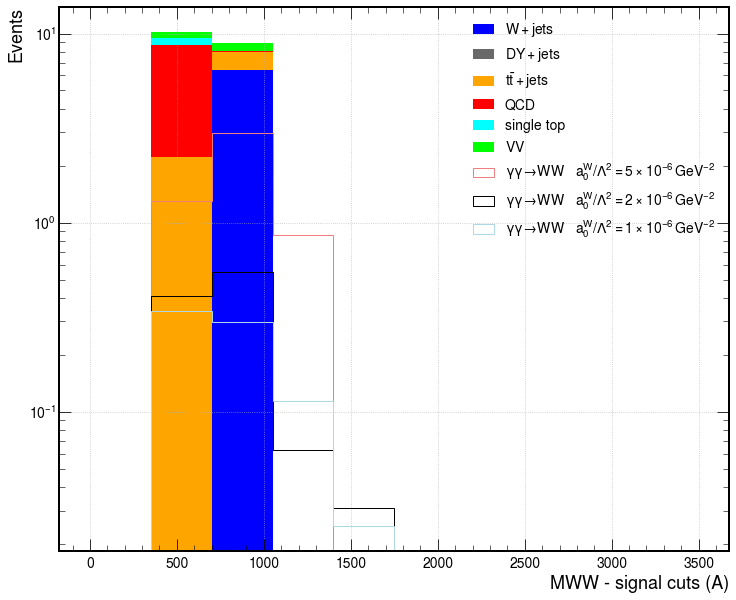

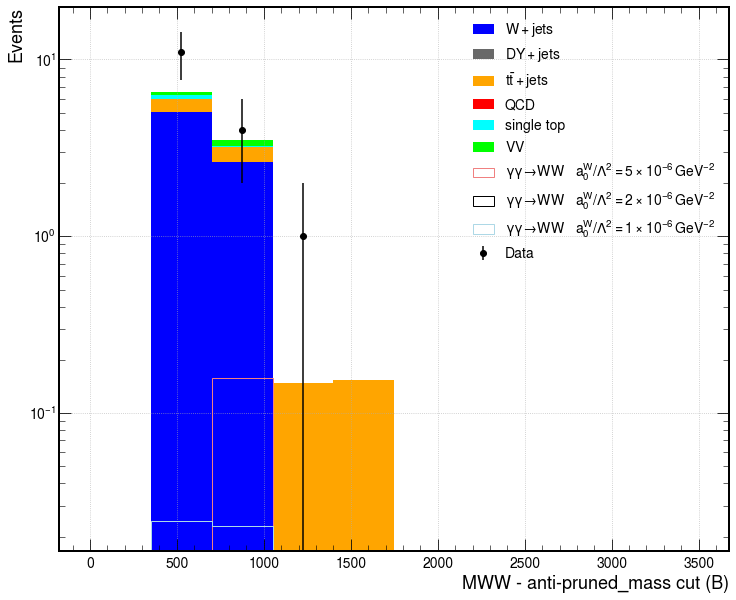

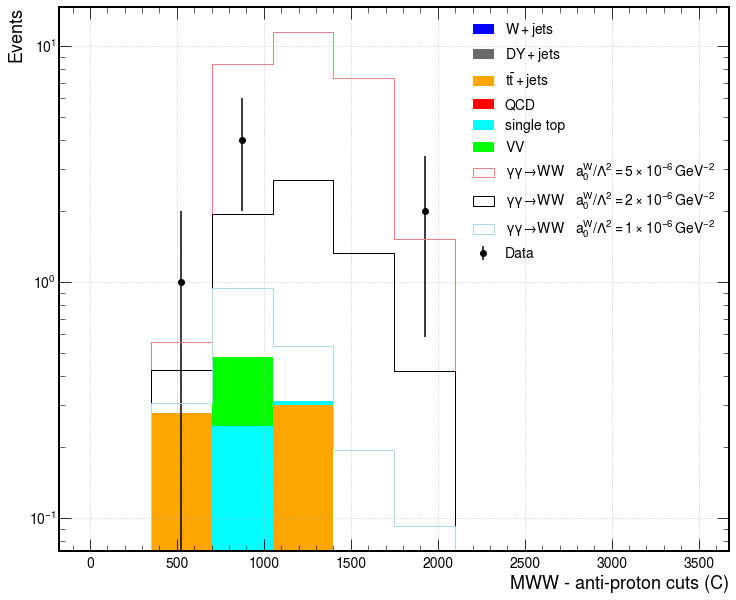

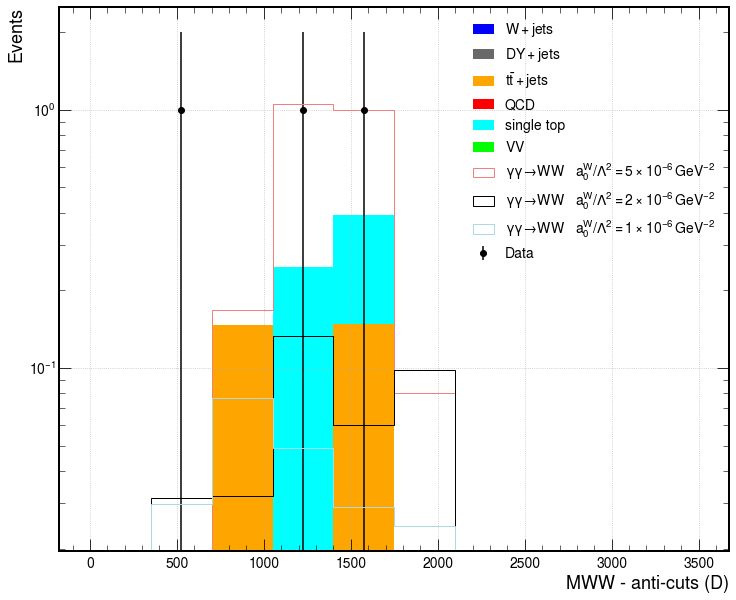

In [39]:
plot_var__ = "MWW"
variation__ = "_nom"
sideband_type__ = "pruned_mass"
#sideband_type__ = "tau21_ddt"

res_bkg, res_sig, res_data = plot_sideband( sideband_type=sideband_type__, plot_var=plot_var__, variation=variation__, df_bkg_events=df_protons_multiRP_bkg_events, df_data__=df_protons_multiRP_data_events )
# res_bkg, res_sig, res_data = plot_sideband( sideband_type=sideband_type__, plot_var=plot_var__, variation=variation__, df_data__=df_protons_multiRP_data_events )
n_events_bkg_mskA, err_n_events_bkg_mskA = res_bkg[ 0 ]
n_events_bkg_mskB, err_n_events_bkg_mskB = res_bkg[ 1 ]
n_events_bkg_mskC, err_n_events_bkg_mskC = res_bkg[ 2 ]
n_events_bkg_mskD, err_n_events_bkg_mskD = res_bkg[ 3 ]
n_events_sig_mskA, err_n_events_sig_mskA = res_sig[ 0 ]
n_events_sig_mskB, err_n_events_sig_mskB = res_sig[ 1 ]
n_events_sig_mskC, err_n_events_sig_mskC = res_sig[ 2 ]
n_events_sig_mskD, err_n_events_sig_mskD = res_sig[ 3 ]
n_events_data_mskA, err_n_events_data_mskA = res_data[ 0 ]
n_events_data_mskB, err_n_events_data_mskB = res_data[ 1 ]
n_events_data_mskC, err_n_events_data_mskC = res_data[ 2 ]
n_events_data_mskD, err_n_events_data_mskD = res_data[ 3 ]

Number of bkg events: [8.32508284845313, 0.0, 7.799901185666501, 12.967329375203745, 1.571484698372566, 2.8429900911976875] +/- [4.225054023865375, 0.0, 1.072657905663193, 9.056096591132452, 0.5938078267846347, 0.8599739099536002]
Number of bkg events (A): [6.450541853598497, 0.0, 3.7146973562801144, 6.617787262753349, 0.7793276730629216, 1.5295044338958035] +/- [3.786446561512574, 0.0, 0.7432913834075702, 6.493968497100116, 0.41291494141302926, 0.6272132155856497]
Number of bkg events (B): [1.8745409948546334, 0.0, 2.6314055438222623, 6.311880881183637, 0.2565576102501472, 1.076230225495436] +/- [1.8745409948546334, 0.0, 0.6211194250780294, 6.311880881183637, 0.24689982968272026, 0.5383944354039406]
Number of bkg events (C): [0.0, 0.0, 0.5798154117335015, 0.0, 0.25475687491953786, 0.2372554318064486] +/- [0.0, 0.0, 0.29079635221460104, 0.0, 0.24443103172941583, 0.2372554318064486]
Number of bkg events (D): [0.0, 0.0, 0.8739828738306228, 0.037661231266760874, 0.28084254013995946, 0.0] 

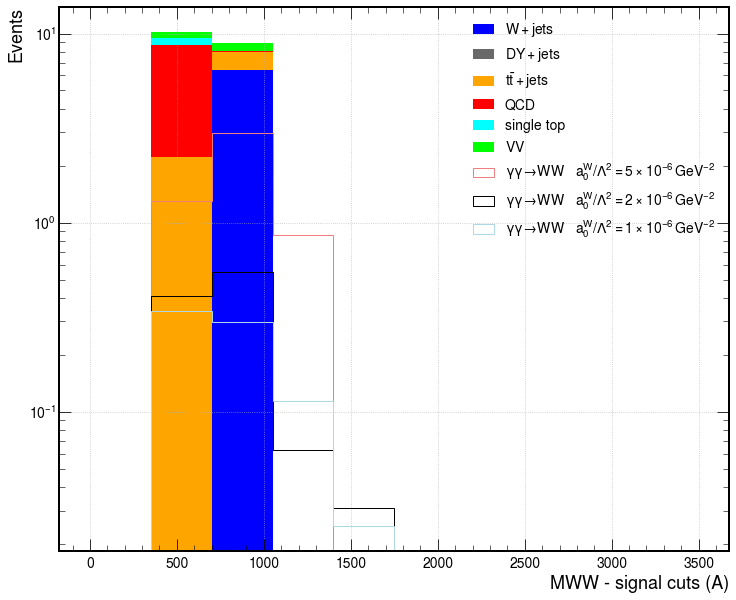

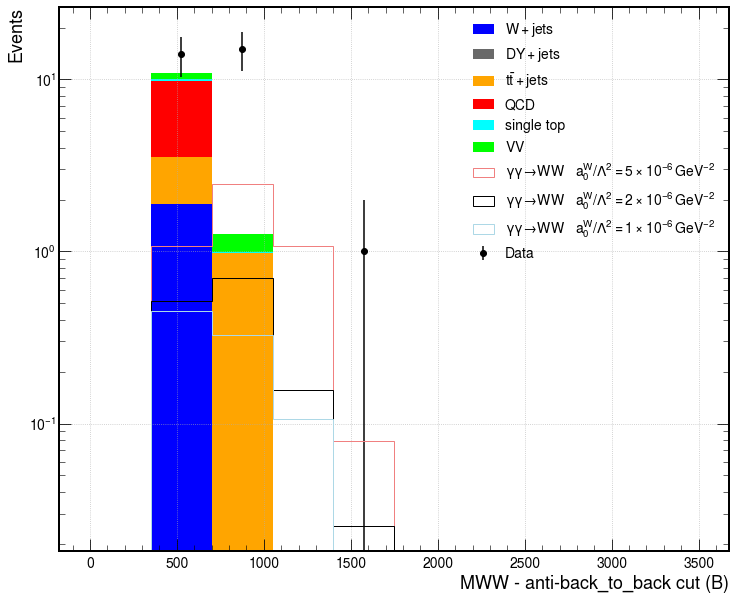

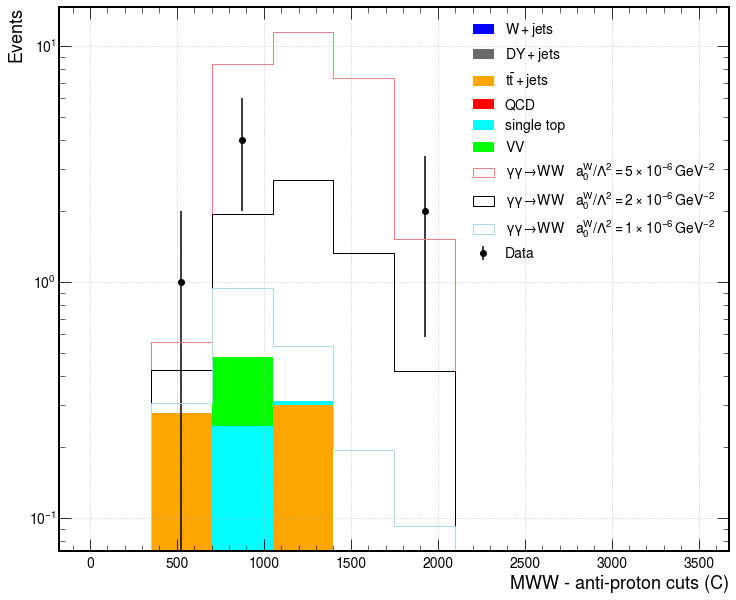

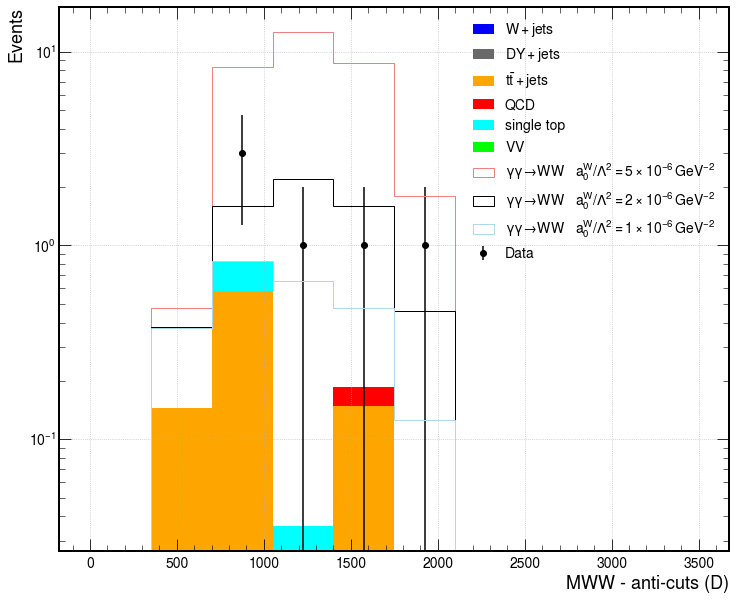

In [41]:
plot_var__ = "MWW"
variation__ = "_nom"
#sideband_type__ = "pruned_mass"
#sideband_type__ = "tau21_ddt"
sideband_type__ = "back_to_back"

res_bkg, res_sig, res_data = plot_sideband( sideband_type=sideband_type__, plot_var=plot_var__, variation=variation__, df_bkg_events=df_protons_multiRP_bkg_events, df_data__=df_protons_multiRP_data_events )
# res_bkg, res_sig, res_data = plot_sideband( sideband_type=sideband_type__, plot_var=plot_var__, variation=variation__, df_data__=df_protons_multiRP_data_events )
n_events_bkg_mskA, err_n_events_bkg_mskA = res_bkg[ 0 ]
n_events_bkg_mskB, err_n_events_bkg_mskB = res_bkg[ 1 ]
n_events_bkg_mskC, err_n_events_bkg_mskC = res_bkg[ 2 ]
n_events_bkg_mskD, err_n_events_bkg_mskD = res_bkg[ 3 ]
n_events_sig_mskA, err_n_events_sig_mskA = res_sig[ 0 ]
n_events_sig_mskB, err_n_events_sig_mskB = res_sig[ 1 ]
n_events_sig_mskC, err_n_events_sig_mskC = res_sig[ 2 ]
n_events_sig_mskD, err_n_events_sig_mskD = res_sig[ 3 ]
n_events_data_mskA, err_n_events_data_mskA = res_data[ 0 ]
n_events_data_mskB, err_n_events_data_mskB = res_data[ 1 ]
n_events_data_mskC, err_n_events_data_mskC = res_data[ 2 ]
n_events_data_mskD, err_n_events_data_mskD = res_data[ 3 ]